# What happens if I fit a mass-gainer with single star models?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d
from scipy.optimize import linear_sum_assignment
import astropy.units as u
from itertools import product
from uncertainties import unumpy
from scipy.stats import chi2

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.6*fs,
          'axes.labelsize': 0.8*fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load and prep data

Add some custom imports will Earl's `mesagrid` package and my mesa plotting scripts.

In [3]:
from importlib import reload
import sys
sys.path.append("../")

import mesagrid
reload(mesagrid);

sys.path.append("../helpers")
import mpt

In [4]:
from types import ModuleType
def refresh_mpt():
    rreload(mpt)
    rreload(mpt)

def rreload(module):
    """Recursively reload modules."""
    reload(module)
    for attribute_name in dir(module):
        attribute = getattr(module, attribute_name)
        if type(attribute) is ModuleType:
            if attribute_name in ["hr", "profiles", "period_spacing", "utils"]:
                rreload(attribute)

In [5]:
track = mesagrid.Track("../output/binaries/D_20", dir_name="LOGS_star2", parameters="Mass-gainer")

In [6]:
single_tracks = {}
Ms = np.arange(2.0, 6.1, 0.1)
x_c_range = np.linspace(1e-5, 0.698, 200)
for M in Ms:
    folder = f"M_{M:1.1f}"
    single_tracks[folder] = mesagrid.Track(dir=f"../output/singles/D_20/{folder}", parameters=folder)
mod_names = [f"M_{M:1.1f}" for M in Ms]

# 1. Fit period spacing pattern

In [7]:
def chi_chains(p_s, p_mg=None, x=None, p_min=1.0, p_max=3.0, longest_chain=False, chain_min=2):
    """Calculate chi^2, aligning periods based on chains of consecutive radial order

    For each chain of consecutive radial order (i.e. subsequent single star period matches subsequent
    mass-gainer period), calculate its length and reduced chi^2. Then pick either the
    longest or lower chi^2 chain to align the rest of the pattern.

    Parameters
    ----------
    p_s : `np.ndarray`
        Single star periods
    p_mg : `np.ndarray`, optional
        Mass-gainer periods, by default None
    x : `np.array`, optional
        Sorted and masked mass-gainer periods (for speed-ups), by default None
    p_min : `float`, optional
        Minimum period, by default 1.0
    p_max : `float`, optional
        Maximum period, by default 3.0
    longest_chain : `bool`, optional
        Whether to use the longest chain instead of minimum chi^2 chain, by default False
    chain_min : `int`, optional
        Minimum length of a chain, by default 1

    Returns
    -------
    chi2 : `float`
        Reduced chi^2 value
    """
    # if x is not directly supplied then compute it
    if x is None:
        # sort mass-gainer periods, remove units, limit period range
        p_mg = np.sort(p_mg.to(u.d).value)
        p_mg = p_mg[(p_mg > p_min) & (p_mg <= p_max)]
    else:
        p_mg = x

    # sort single star periods, remove units, limit period range
    p_s = np.sort(p_s.to(u.d).value)
    p_s = p_s[(p_s > p_min) & (p_s <= p_max)]

    # convert to frequency and back to period with uncertainties
    f_mg = 1 / p_mg
    f_mg_with_unc = unumpy.uarray(f_mg, np.ones(len(f_mg)) / 1150)
    p_mg_with_unc = 1 / f_mg_with_unc
    sigmas = unumpy.std_devs(p_mg_with_unc)

    # indices of closest single star periods to each mass-gainer period
    inds_s = np.asarray([np.argmin(np.abs(p_s - p)) for p in p_mg])

    # empty arrays for storing length and chi2 of chains, cursor for tracking
    # arrays are way too big to avoid growing them, will trim after
    BIG_BUT_RANDOM_NUMBER = 1000
    lengths = np.zeros(BIG_BUT_RANDOM_NUMBER).astype(int)
    chi2 =  np.zeros(BIG_BUT_RANDOM_NUMBER)
    offsets = np.zeros(BIG_BUT_RANDOM_NUMBER).astype(int)
    cursor = 0

    ## we are going to loop over the indices and sum chi^2 for contiguous blocks, storing that chi^2 + length
    # base condition
    lengths[0] += 1
    chi2[0] += (p_s[inds_s[0]] - p_mg[0])**2
    offsets[0] = inds_s[0]

    # step through each mass-gainer period
    for i in range(1, len(p_mg)):
        # if the closest single star period is not *also* the next radial order then start a new chain
        if inds_s[i] - inds_s[i - 1] != 1:
            cursor += 1
            offsets[cursor] = inds_s[i] - i

        # increment the length of the current chain and add to its chi^2
        lengths[cursor] += 1
        chi2[cursor] += (p_s[inds_s[i]] - p_mg[i])**2 / sigmas[i]**2
    # avoid off-by-one errors
    cursor += 1

    # trim useless empty part of arrays as promised
    chi2 = chi2[:cursor]
    lengths = lengths[:cursor]
    offsets = offsets[:cursor]

    # keep only chains with at least two periods
    chi2 = chi2[lengths >= chain_min]
    offsets = offsets[lengths >= chain_min]
    lengths = lengths[lengths >= chain_min]

    # convert to reduced chi2
    reduced_chi2 = chi2 / (lengths - 1)

    # just in case no chains were found
    if len(reduced_chi2) < 1:
        return 1e10

    # work out the offset between indices based either on the longest chain or just the minimum chi^2
    offset = offsets[np.argmax(lengths) if longest_chain else np.argmin(reduced_chi2)]

    # use offset to work out the matched indices
    matched_mg_inds = np.arange(len(p_mg))
    matched_s_inds = matched_mg_inds + offset

    # mask the indices (relevant in cases where there are fewer modes in single star model)
    allowed = (matched_s_inds >= 0) & (matched_s_inds < len(p_s))
    matched_mg_inds = matched_mg_inds[allowed]
    matched_s_inds = matched_s_inds[allowed]

    return sum((p_mg[matched_mg_inds] - p_s[matched_s_inds])**2 / sigmas[matched_mg_inds])

In [8]:
def get_all_chis(X_c=0.2, **kwargs):
    p_mg, _, _ = mpt.get_delta_p(track, X_c=X_c)
    p_mg = np.sort(p_mg.to(u.d).value)
    x = p_mg[(p_mg > 1.0) & (p_mg <= 3.0)]

    return [[chi_chains(p_s=mpt.get_delta_p(single_tracks[mod_name], mod=i)[0], x=x, **kwargs)
             for i in range(len(single_tracks[mod_name].freqs))] for mod_name in mod_names]

In [9]:
cmap = plt.get_cmap('cividis_r').copy()
cmap.set_extremes(bad="black", over=cmap(1.0))

In [137]:
def plot_chis(chis, X_c, truth_col='pink', best_fit_col='cyan', save=True, factor=1, marginals=False):
    x_cs = [single_tracks[mod_name].history["center_h1"].values for mod_name in mod_names]

    chi_funcs = [interp1d(x_c, np.array(chi), fill_value="extrapolate") for x_c, chi in zip(x_cs, chis)]

    x_c_range = np.linspace(1e-5, 0.698, 200)

    XC, M = np.meshgrid(x_c_range, Ms)

    CHI = np.asarray([chi_funcs[i](x_c_range) for i in range(len(chi_funcs))])
    CHI *= factor
    CHI[CHI > 100000] = np.inf

    # critical_value = chi2(1).ppf(0.95)
    critical_value = CHI.min() + 1

    if marginals:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                                 gridspec_kw={"hspace": 0, "wspace": 0, 
                                              "height_ratios": [1, 4], "width_ratios": [4, 1]})
        ax = axes[1, 0]
        axes[0, 1].axis("off")
        fig.subplots_adjust(hspace=0.1, wspace=0.1)
    else:
        fig, ax = plt.subplots()

    levels = np.linspace(0, 3, 16)
    cont = ax.contourf(XC, M, np.log10(CHI), levels=levels, cmap=cmap, extend='both')
    ax.contour(XC, M, np.log10(CHI), levels=[np.log10(critical_value)], colors="white", zorder=10)
    for c in cont.collections:
        c.set_edgecolor("face")
        c.set_rasterized(True)
    cbar = fig.colorbar(cont, label=r"$\log_{10}(\chi^2)$", ax=axes)
    
    # plot a white line to colourbar critical chi^2 value
    cbar.ax.plot([0, 1], [np.log10(critical_value)]*2, color="white", lw=2)

    M_ind, x_c_ind = np.unravel_index(np.argmin(CHI), CHI.shape)

    print(X_c, f'{x_c_range[x_c_ind]:1.3f}', f'{Ms[M_ind]:1.3f}')

    xlims, ylims = ax.get_xlim(), ax.get_ylim()

    lw, ls, bf_ls = 2, "-", '-'

    ax.plot([X_c, X_c], [2.0, 3.5], color=truth_col, linestyle=ls, lw=lw,
            label=r"Truth ($X_c = $" + f"{X_c}, " + r"$M = $" + "3.5)")
    ax.plot([0, X_c], [3.5, 3.5], color=truth_col, linestyle=ls, lw=lw)
    ax.scatter(X_c, 3.5, color=truth_col, s=35)

    ax.plot([x_c_range[x_c_ind], x_c_range[x_c_ind]], [2.0, Ms[M_ind]], color=best_fit_col, linestyle=bf_ls, lw=lw,
            label=r"Best fit ($X_c = $" + f"{x_c_range[x_c_ind]:1.2f}, " + r"$M = $" + f"{Ms[M_ind]:1.1f})")
    ax.plot([0, x_c_range[x_c_ind]], [Ms[M_ind], Ms[M_ind]], color=best_fit_col, linestyle=bf_ls, lw=lw)
    ax.scatter(x_c_range[x_c_ind], Ms[M_ind], color=best_fit_col, s=35)

    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_ylim(top=5.99)
    ax.set_xlim(left=2.5e-3)

    ax.legend(loc="best", framealpha=0.1, labelcolor="white", fontsize=0.9*fs)

    ax.set_xlabel(r"Central hydrogen fraction, $X_c$", fontsize=fs)
    ax.set_ylabel(r"Stellar mass, $M \, [\rm M_\odot]$", fontsize=fs)

    if marginals:
        Xc_smooth = np.linspace(0, 0.7, 1000)
        CHI_smooth = interp1d(x_c_range, CHI.min(axis=0), fill_value="extrapolate")(Xc_smooth)
        axes[0, 0].plot(Xc_smooth, CHI_smooth, color=cmap(0.999), lw=2)
        axes[0, 0].fill_between(Xc_smooth, CHI_smooth, 30, alpha=0.8, color=cmap(0.999))
        axes[0, 0].set(xlim=ax.get_xlim(), ylim=(CHI.min() * 0.5, 30), yscale="log", ylabel=r"$\chi^2_{\rm min}$")
        axes[0, 0].spines[["bottom", "top", "right"]].set_visible(False)
        # axes[0, 0].axhline(chi2(1).ppf(0.95), color="white", linestyle="-")
        axes[0, 0].fill_between(Xc_smooth, CHI_smooth, critical_value,
                                where=CHI_smooth <= critical_value, facecolor=cmap(0.0))

        M_smooth = np.linspace(2.0, 6.0, 1000)
        CHI_smooth = interp1d(Ms, CHI.min(axis=1), fill_value="extrapolate")(M_smooth)
        axes[1, 1].plot(CHI_smooth, M_smooth, color=cmap(0.999), lw=2)
        axes[1, 1].fill_betweenx(y=M_smooth, x1=CHI_smooth, x2=1e3, alpha=0.8, color=cmap(0.999))
        axes[1, 1].set(ylim=ax.get_ylim(), xlim=(CHI.min() * 0.5, 1000), xscale="log", xlabel=r"$\chi^2_{\rm min}$")
        axes[1, 1].spines[["left", "top", "right"]].set_visible(False)
        axes[1, 1].set_yticks([])
        # axes[1, 1].axvline(chi2(1).ppf(0.95), color="white")
        axes[1, 1].fill_betweenx(y=M_smooth, x1=CHI_smooth, x2=critical_value,
                                where=CHI_smooth <= critical_value, facecolor=cmap(0.0))

    if save:
        plt.savefig(f"../paper/figures/chi2_xc_{X_c}.pdf", format="pdf", bbox_inches="tight", dpi=300)

    plt.show()

In [ ]:
X_c_range = [0.47, 0.4, 0.3, 0.2, 0.1, 0.01]
chi_sigma_1 = [get_all_chis(X_c=X_c) for X_c in X_c_range]

66     113.467698
76     138.114844
92     168.859708
109    192.677733
127    211.544332
144    224.755329
Name: star_age, dtype: float64

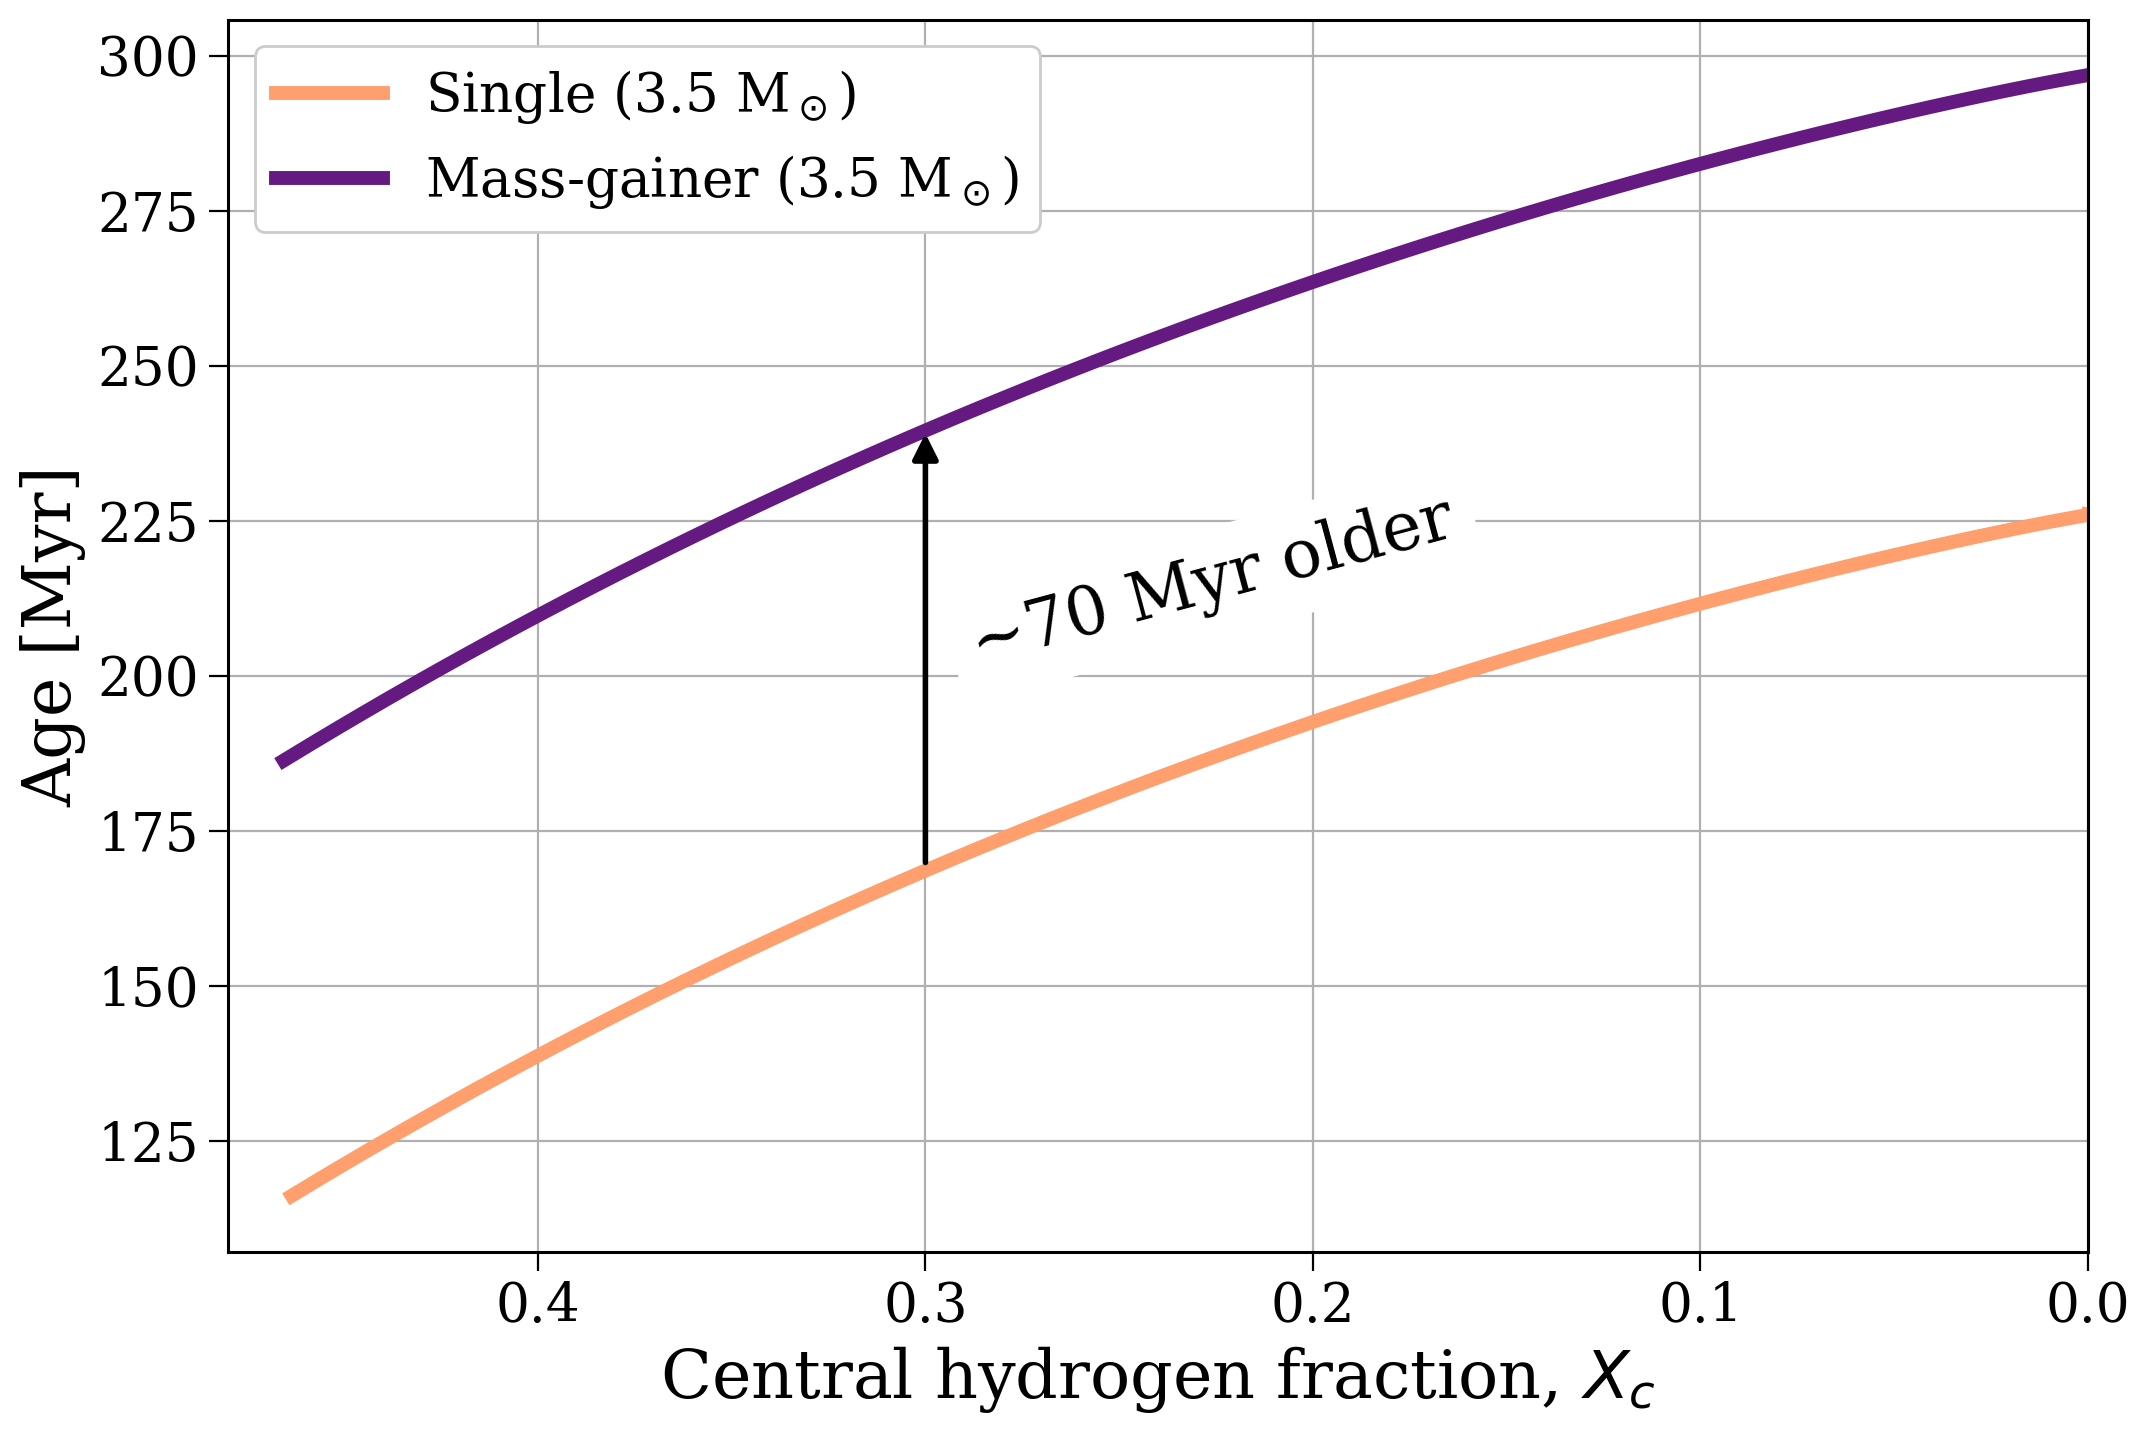

In [134]:
fig, ax = plt.subplots()

plt.plot(single_tracks["M_3.5"].history["center_h1"][single_tracks["M_3.5"].history["center_h1"] <= 0.47],
         single_tracks["M_3.5"].history["star_age"][single_tracks["M_3.5"].history["center_h1"] <= 0.47] / 1e6,
         color=mpt.utils.single_col, lw=5, label=r"Single (3.5 M$_\odot$)")
plt.plot(track.history["center_h1"][track.history["center_h1"] <= 0.47],
         track.history["star_age"][track.history["center_h1"] <= 0.47] / 1e6,
         color=mpt.utils.mass_gainer_col, lw=5, label=r"Mass-gainer (3.5 M$_\odot$)")
plt.xlabel("Central hydrogen fraction, $X_c$", fontsize=fs)
plt.ylabel("Age [Myr]", fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=0.8*fs)
plt.xlim(0.48, 0)

plt.legend(loc="best", fontsize=0.8*fs, framealpha=1)

ax.annotate("", (0.3, 240), (0.3, 169), fontsize=fs*0.8, ha="center", va="bottom", color="black", arrowprops=dict(facecolor='black', arrowstyle="-|>", lw=2))
ax.annotate("~70 Myr older", (0.29, 215), fontsize=fs, ha="left", va="center", color="black", rotation=15, bbox=dict(facecolor='white', edgecolor="white", boxstyle='round'))
plt.grid()

0.47 0.642 3.500


/home/tom/miniconda3/envs/kavli/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


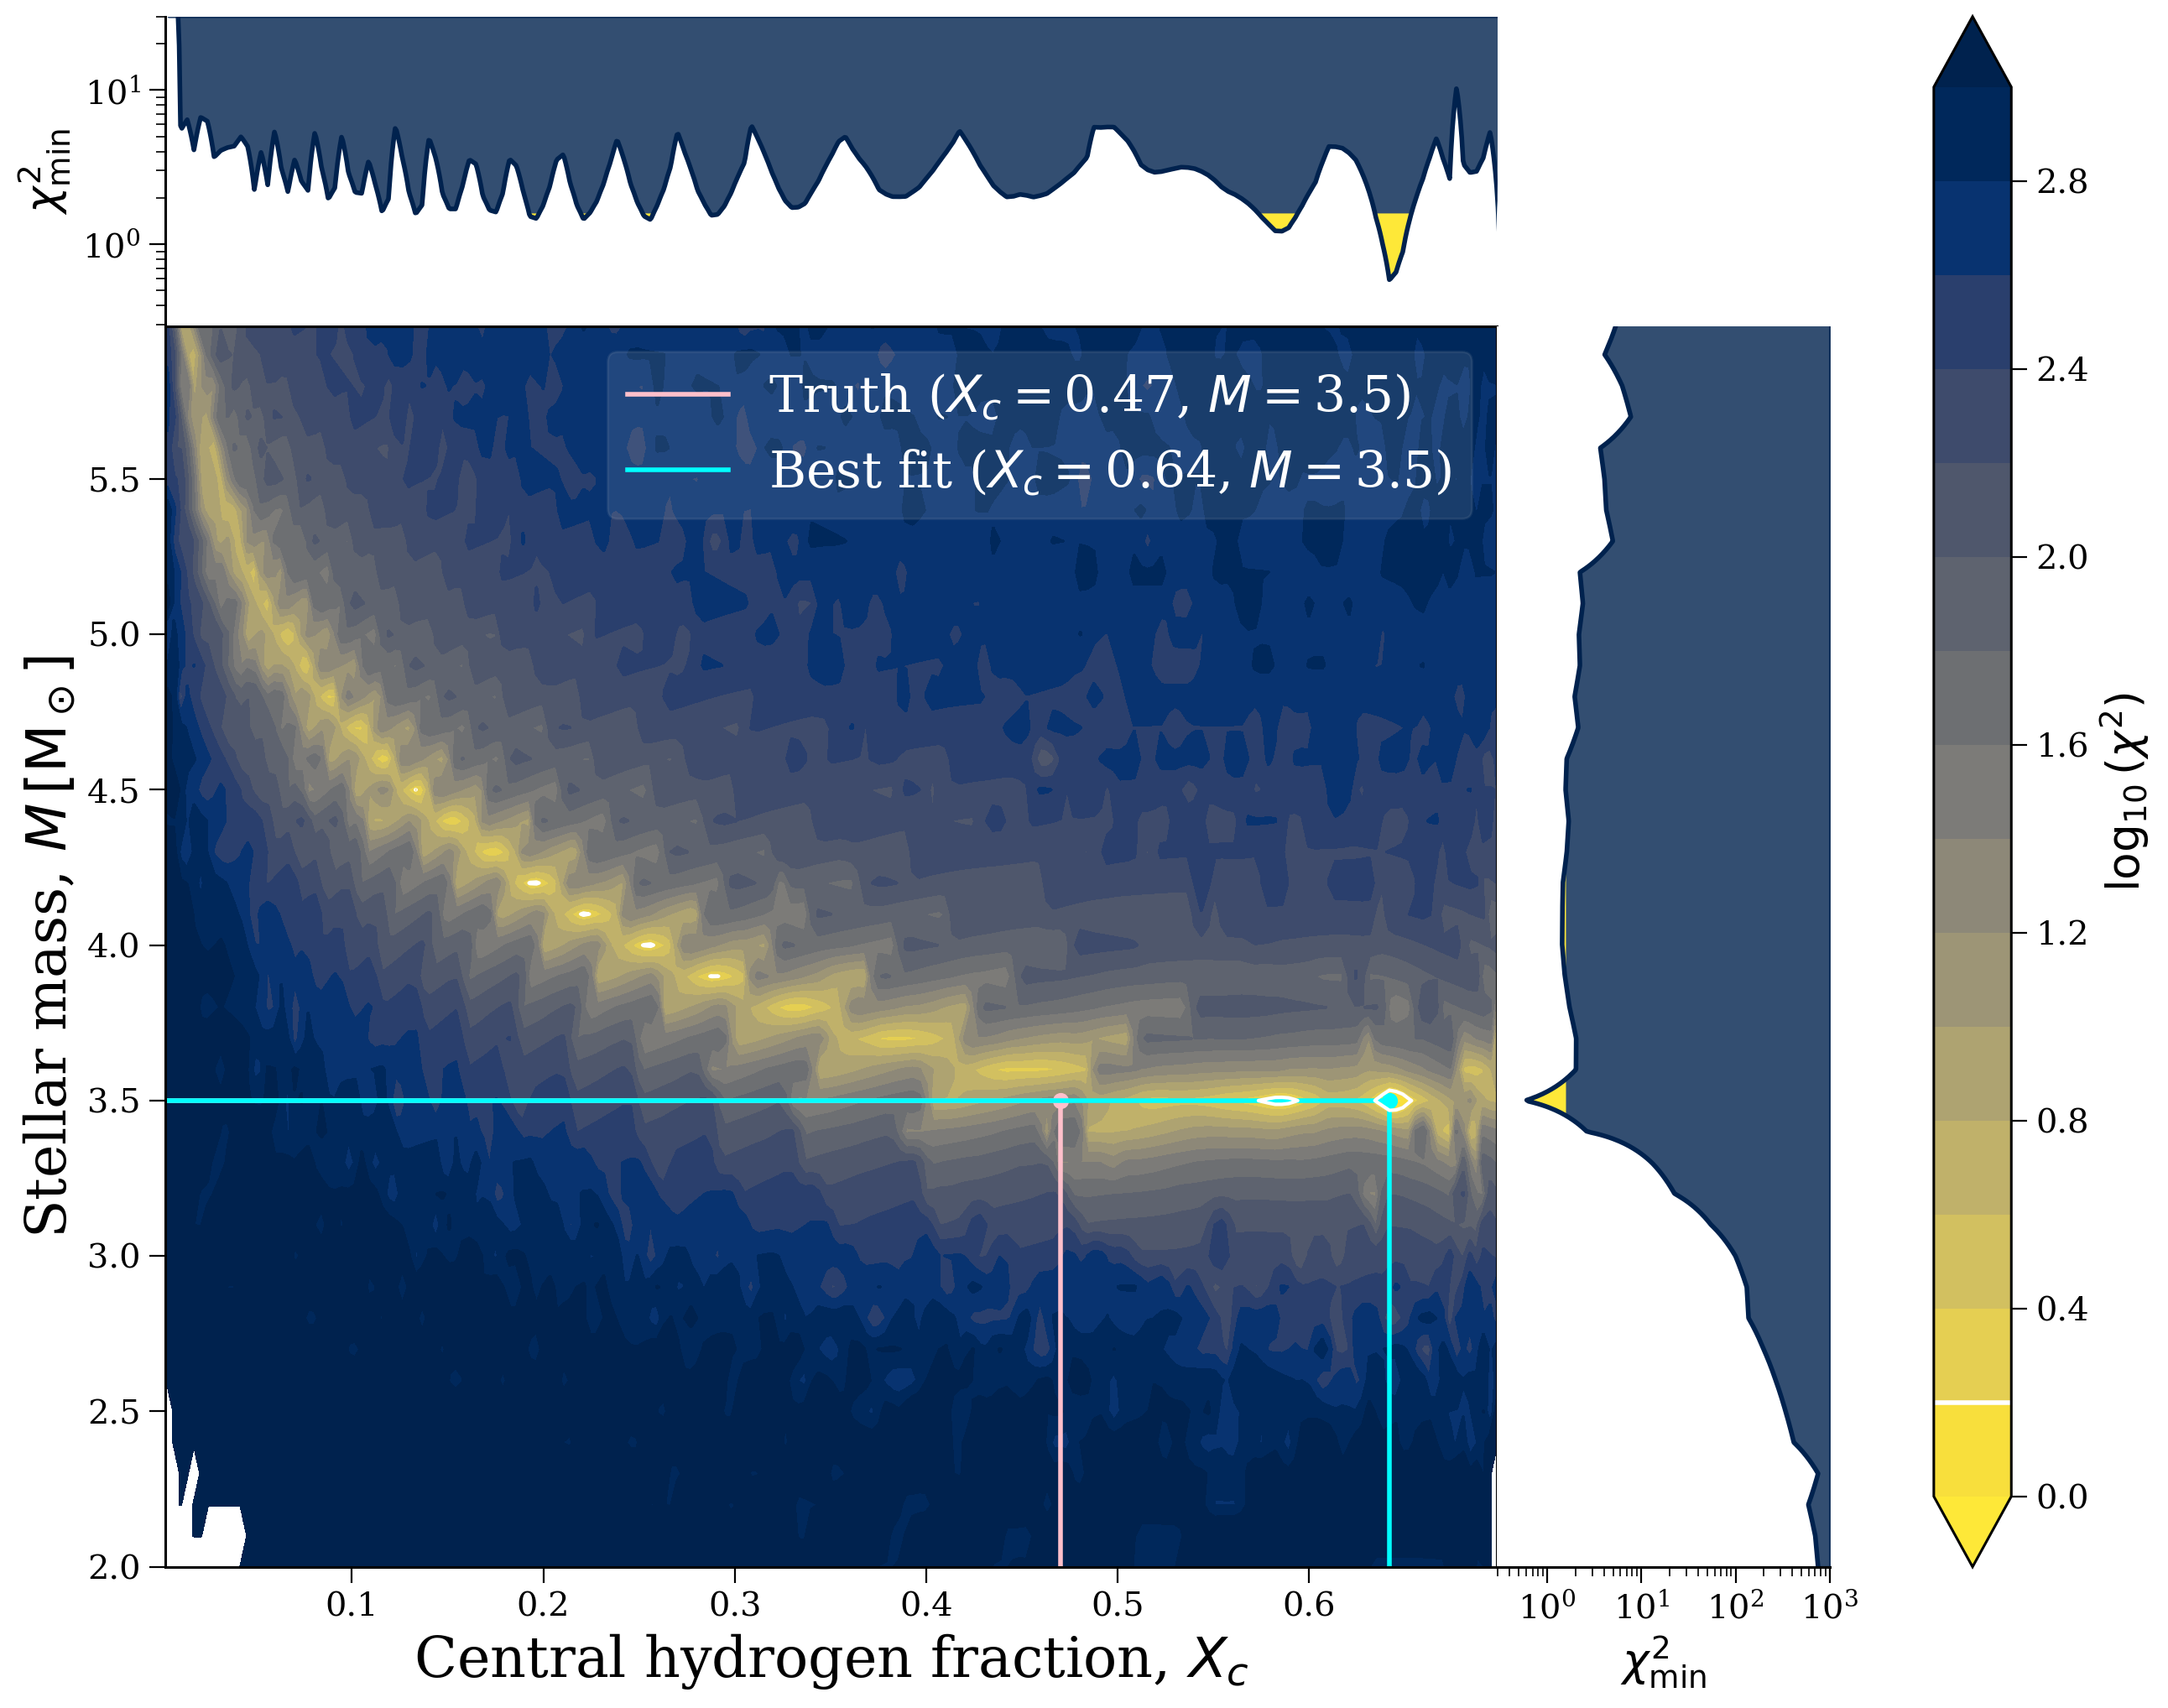

0.4 0.417 3.500


/home/tom/miniconda3/envs/kavli/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


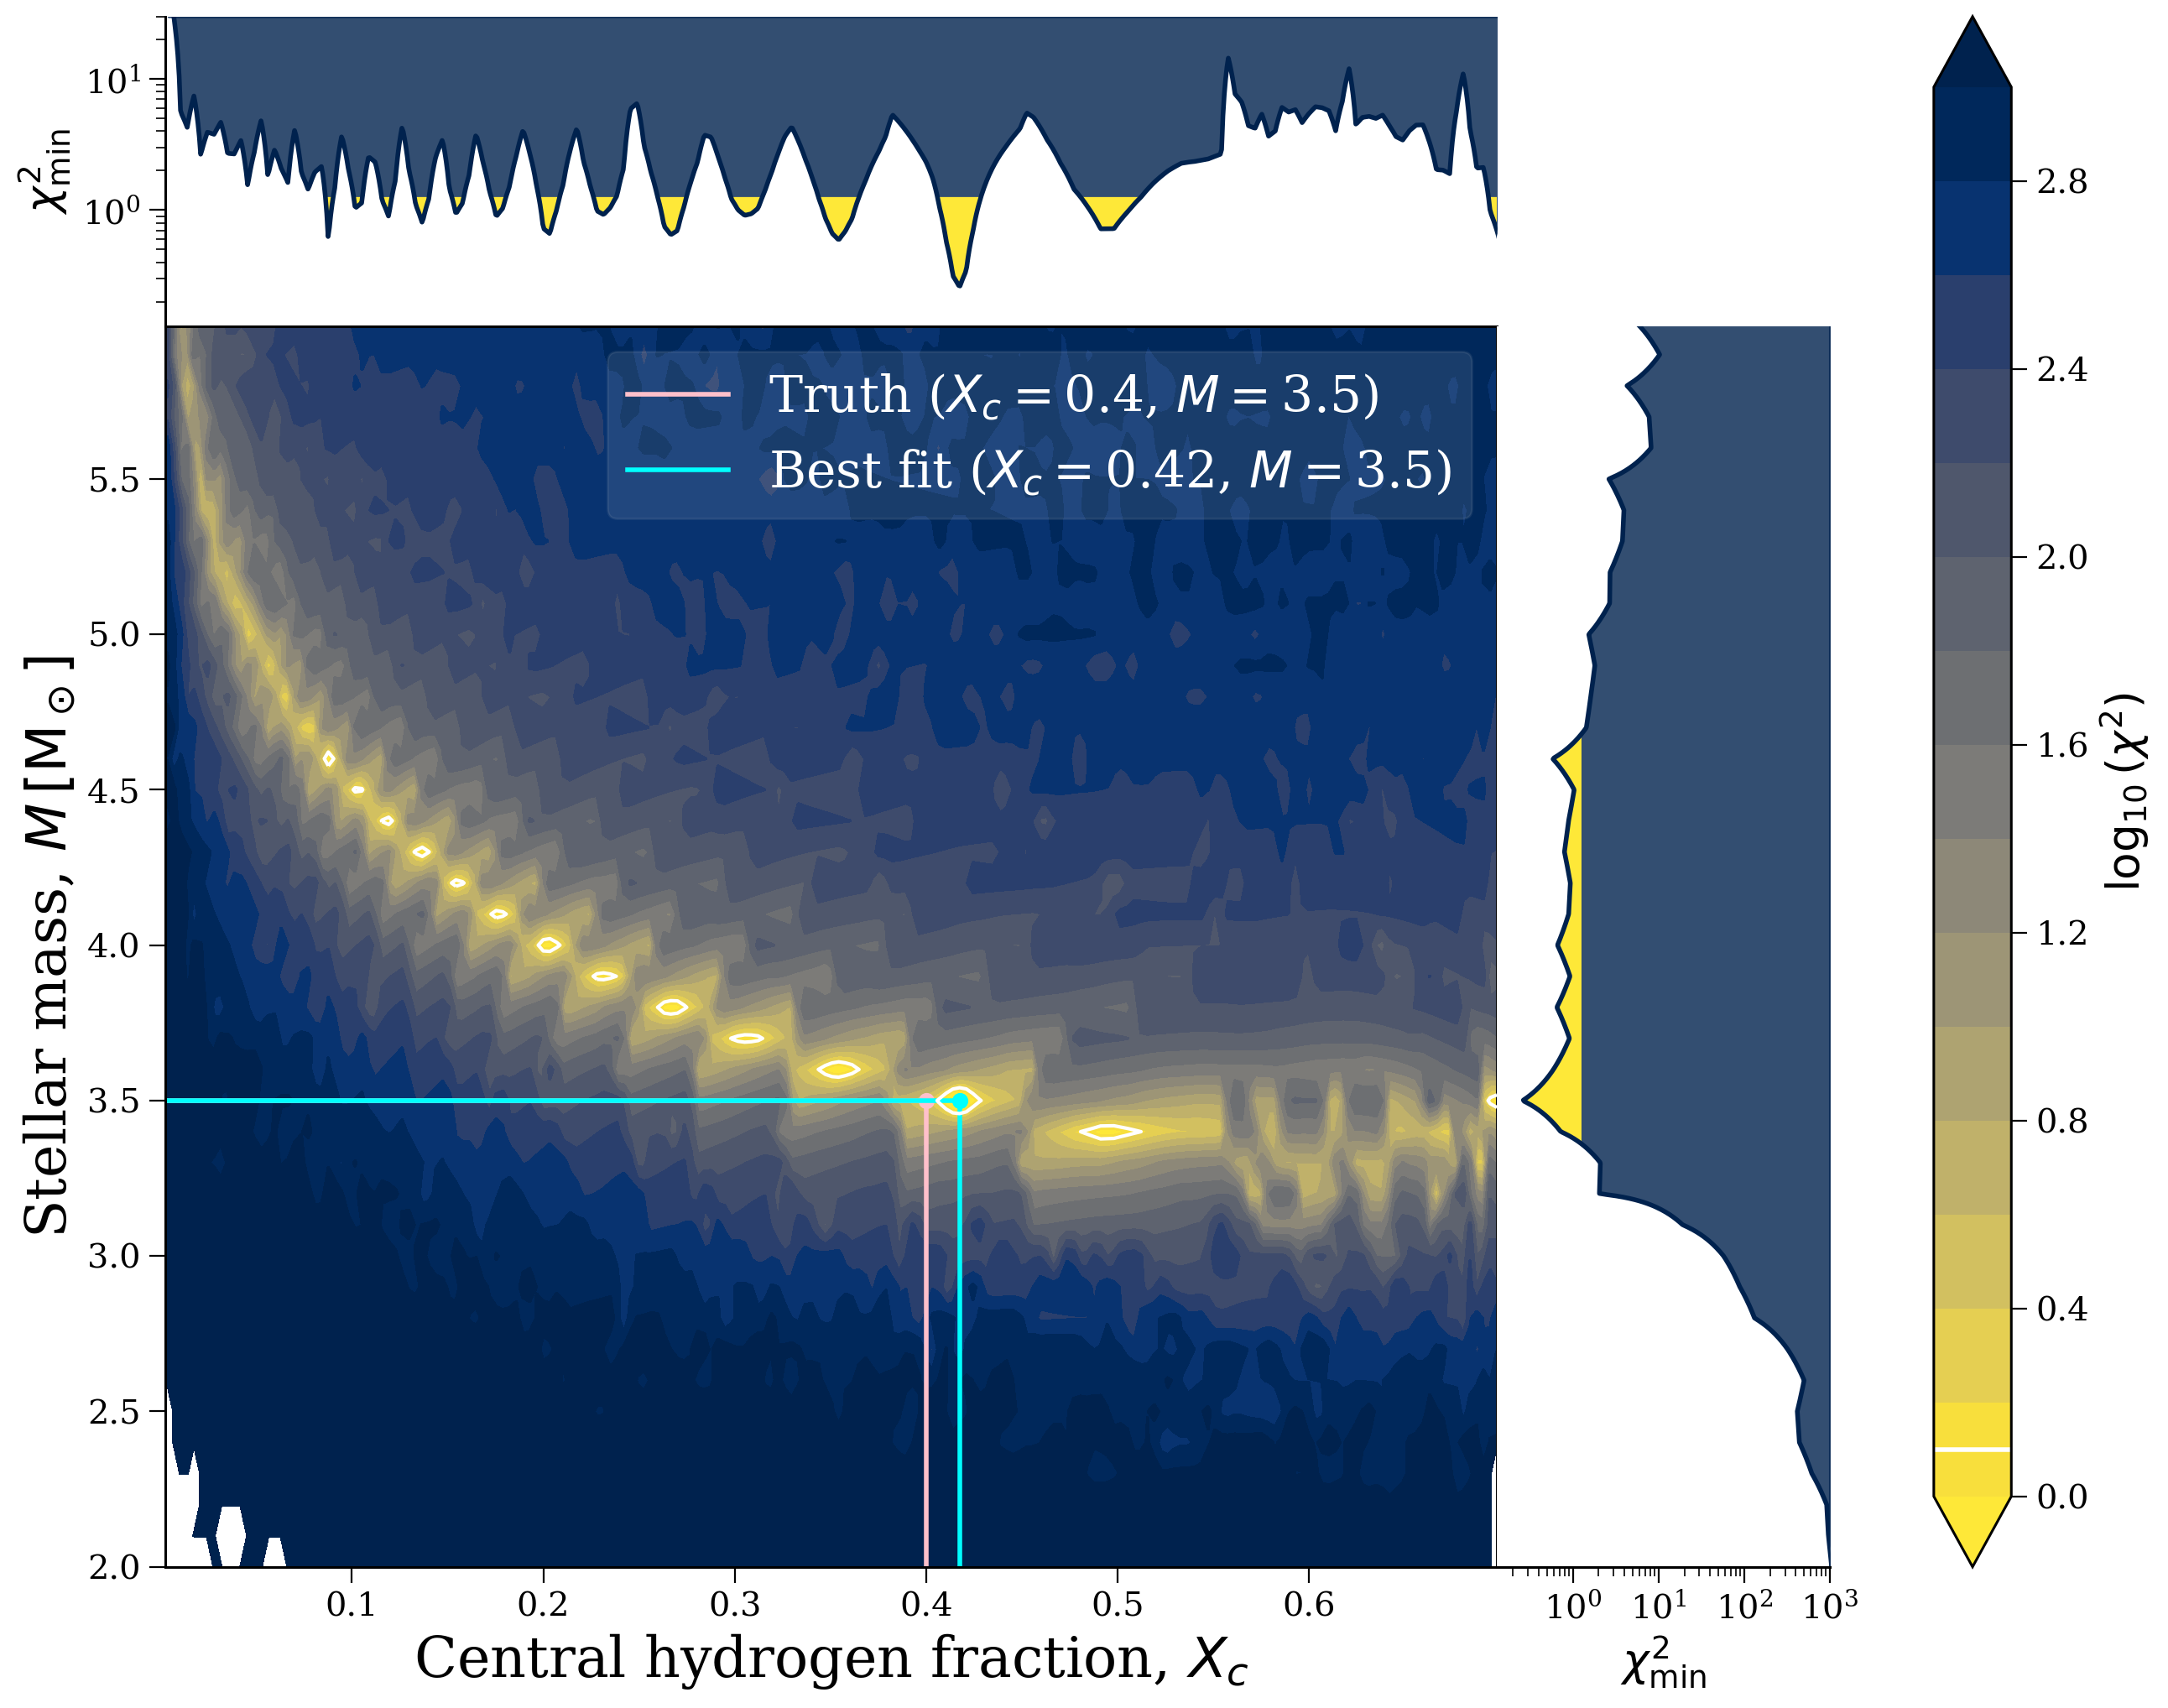

0.3 0.312 3.500


/home/tom/miniconda3/envs/kavli/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


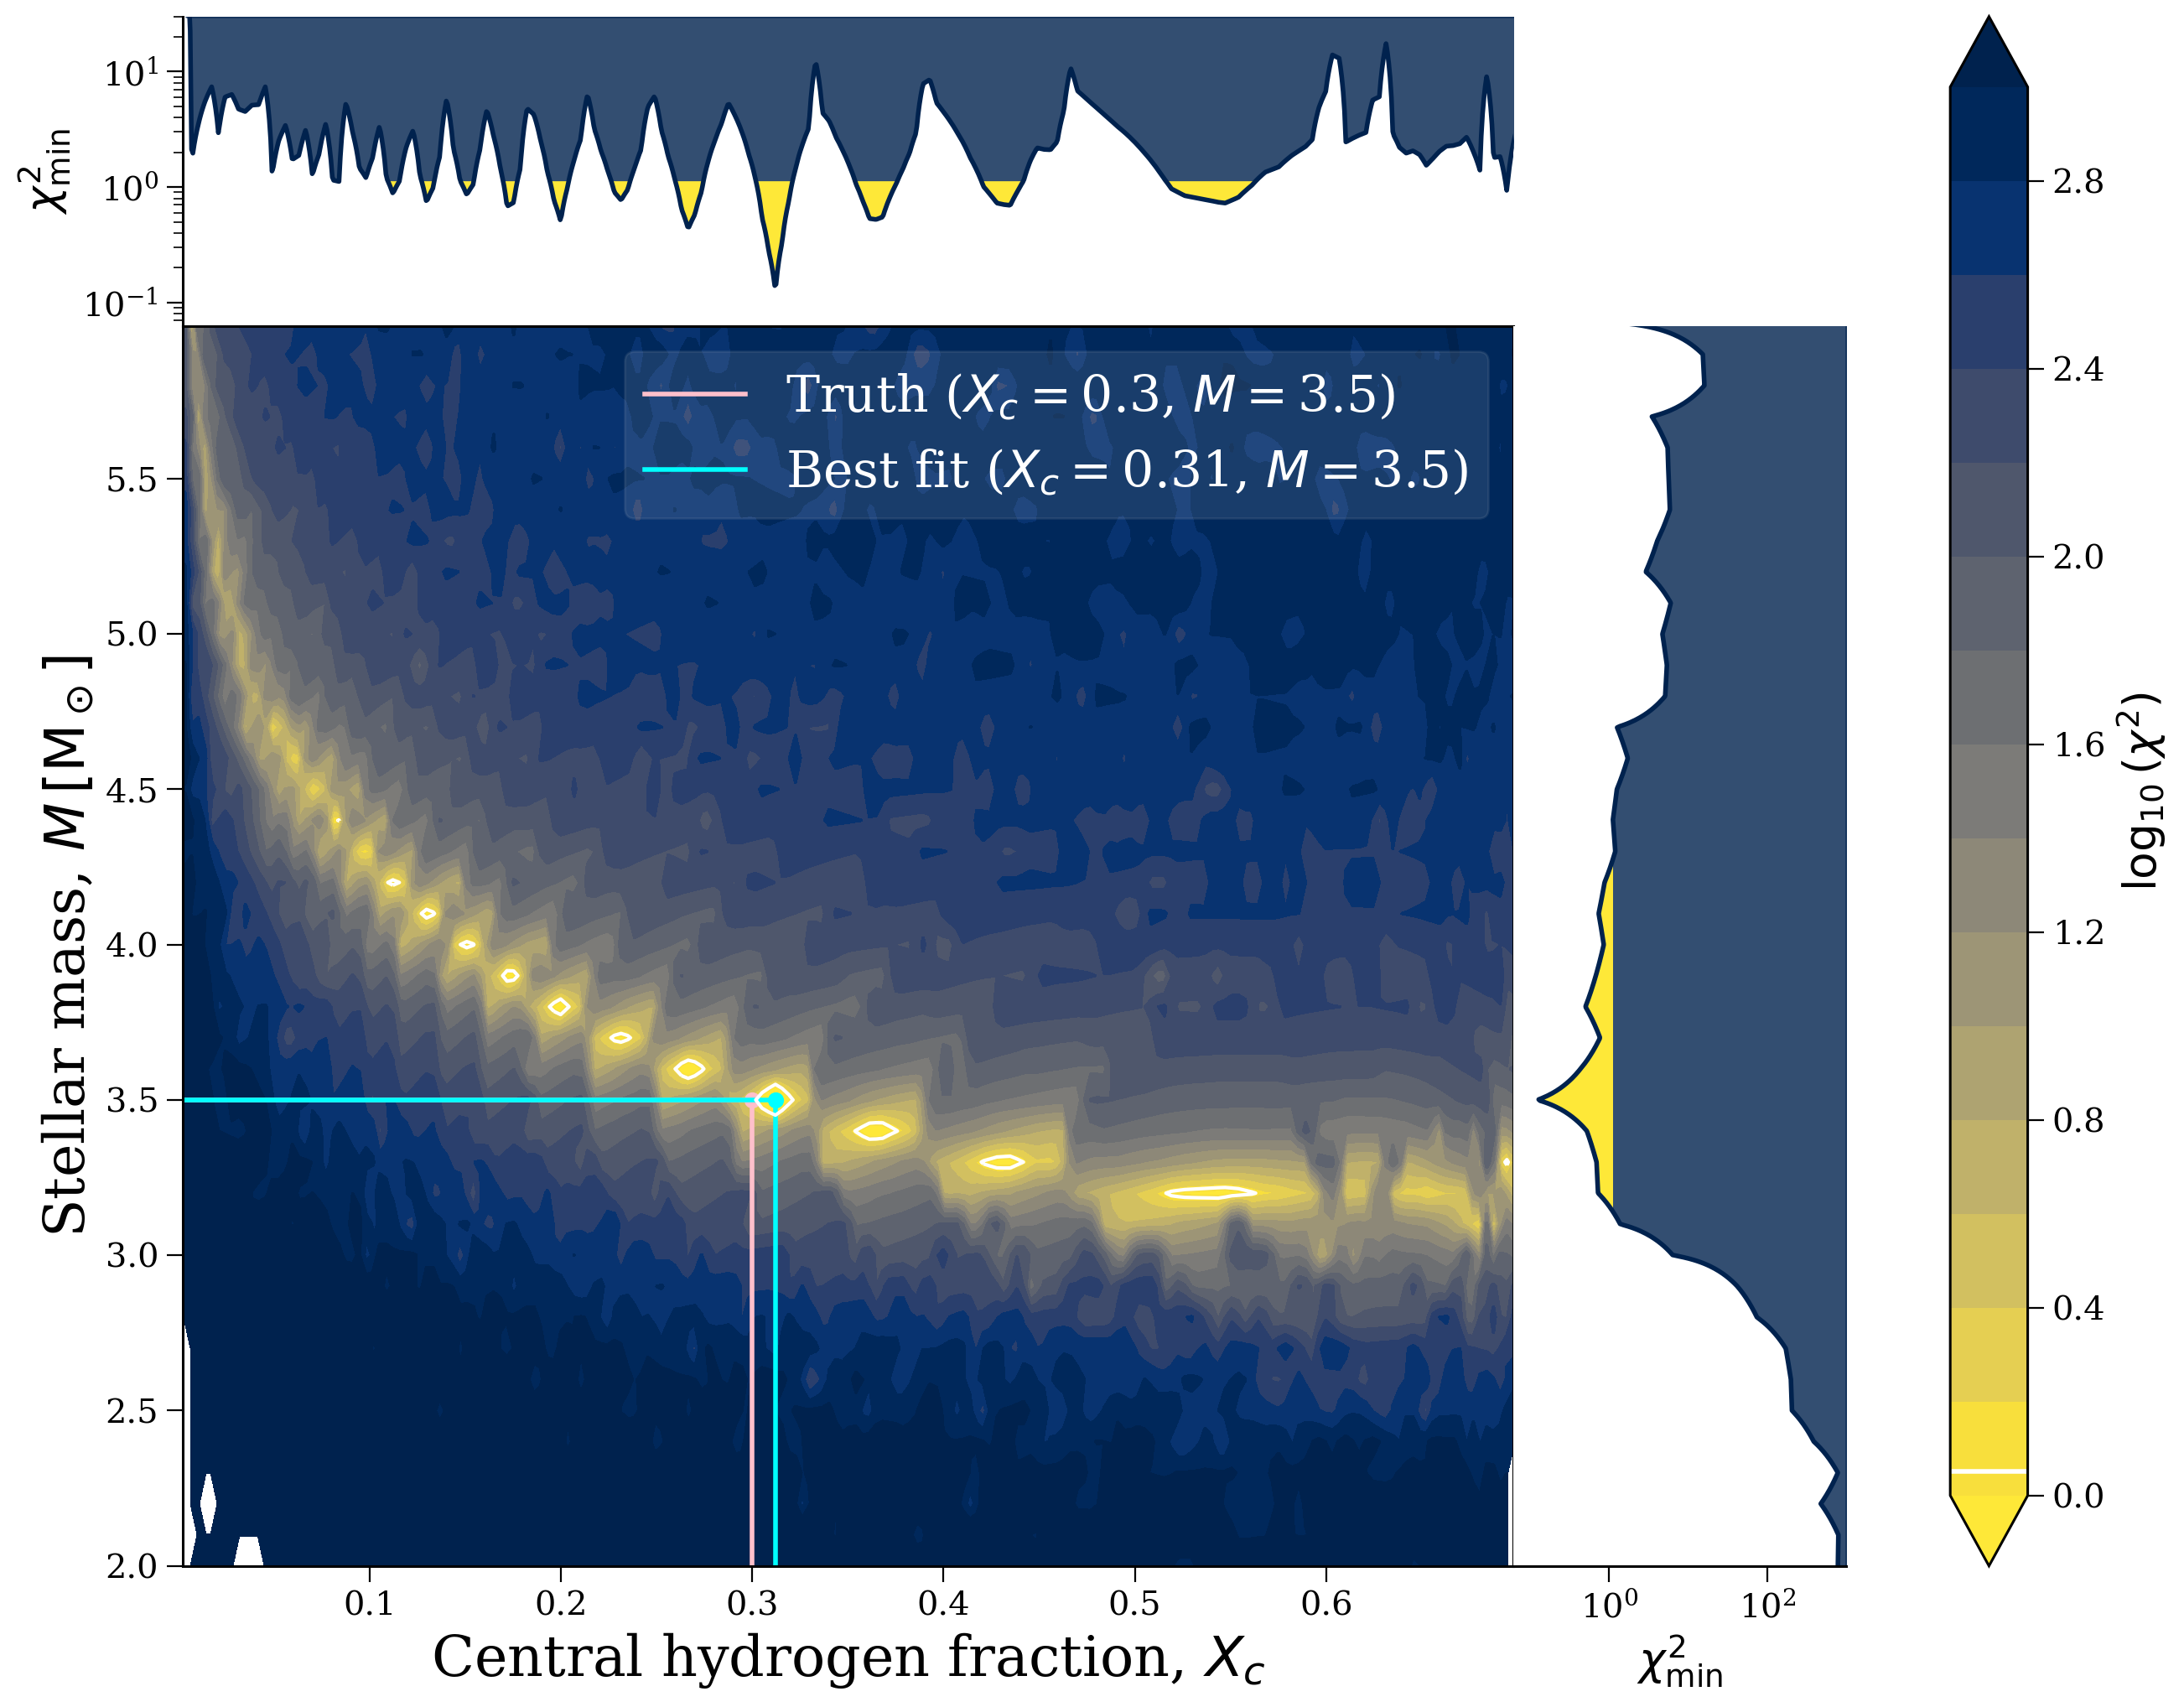

0.2 0.210 3.500


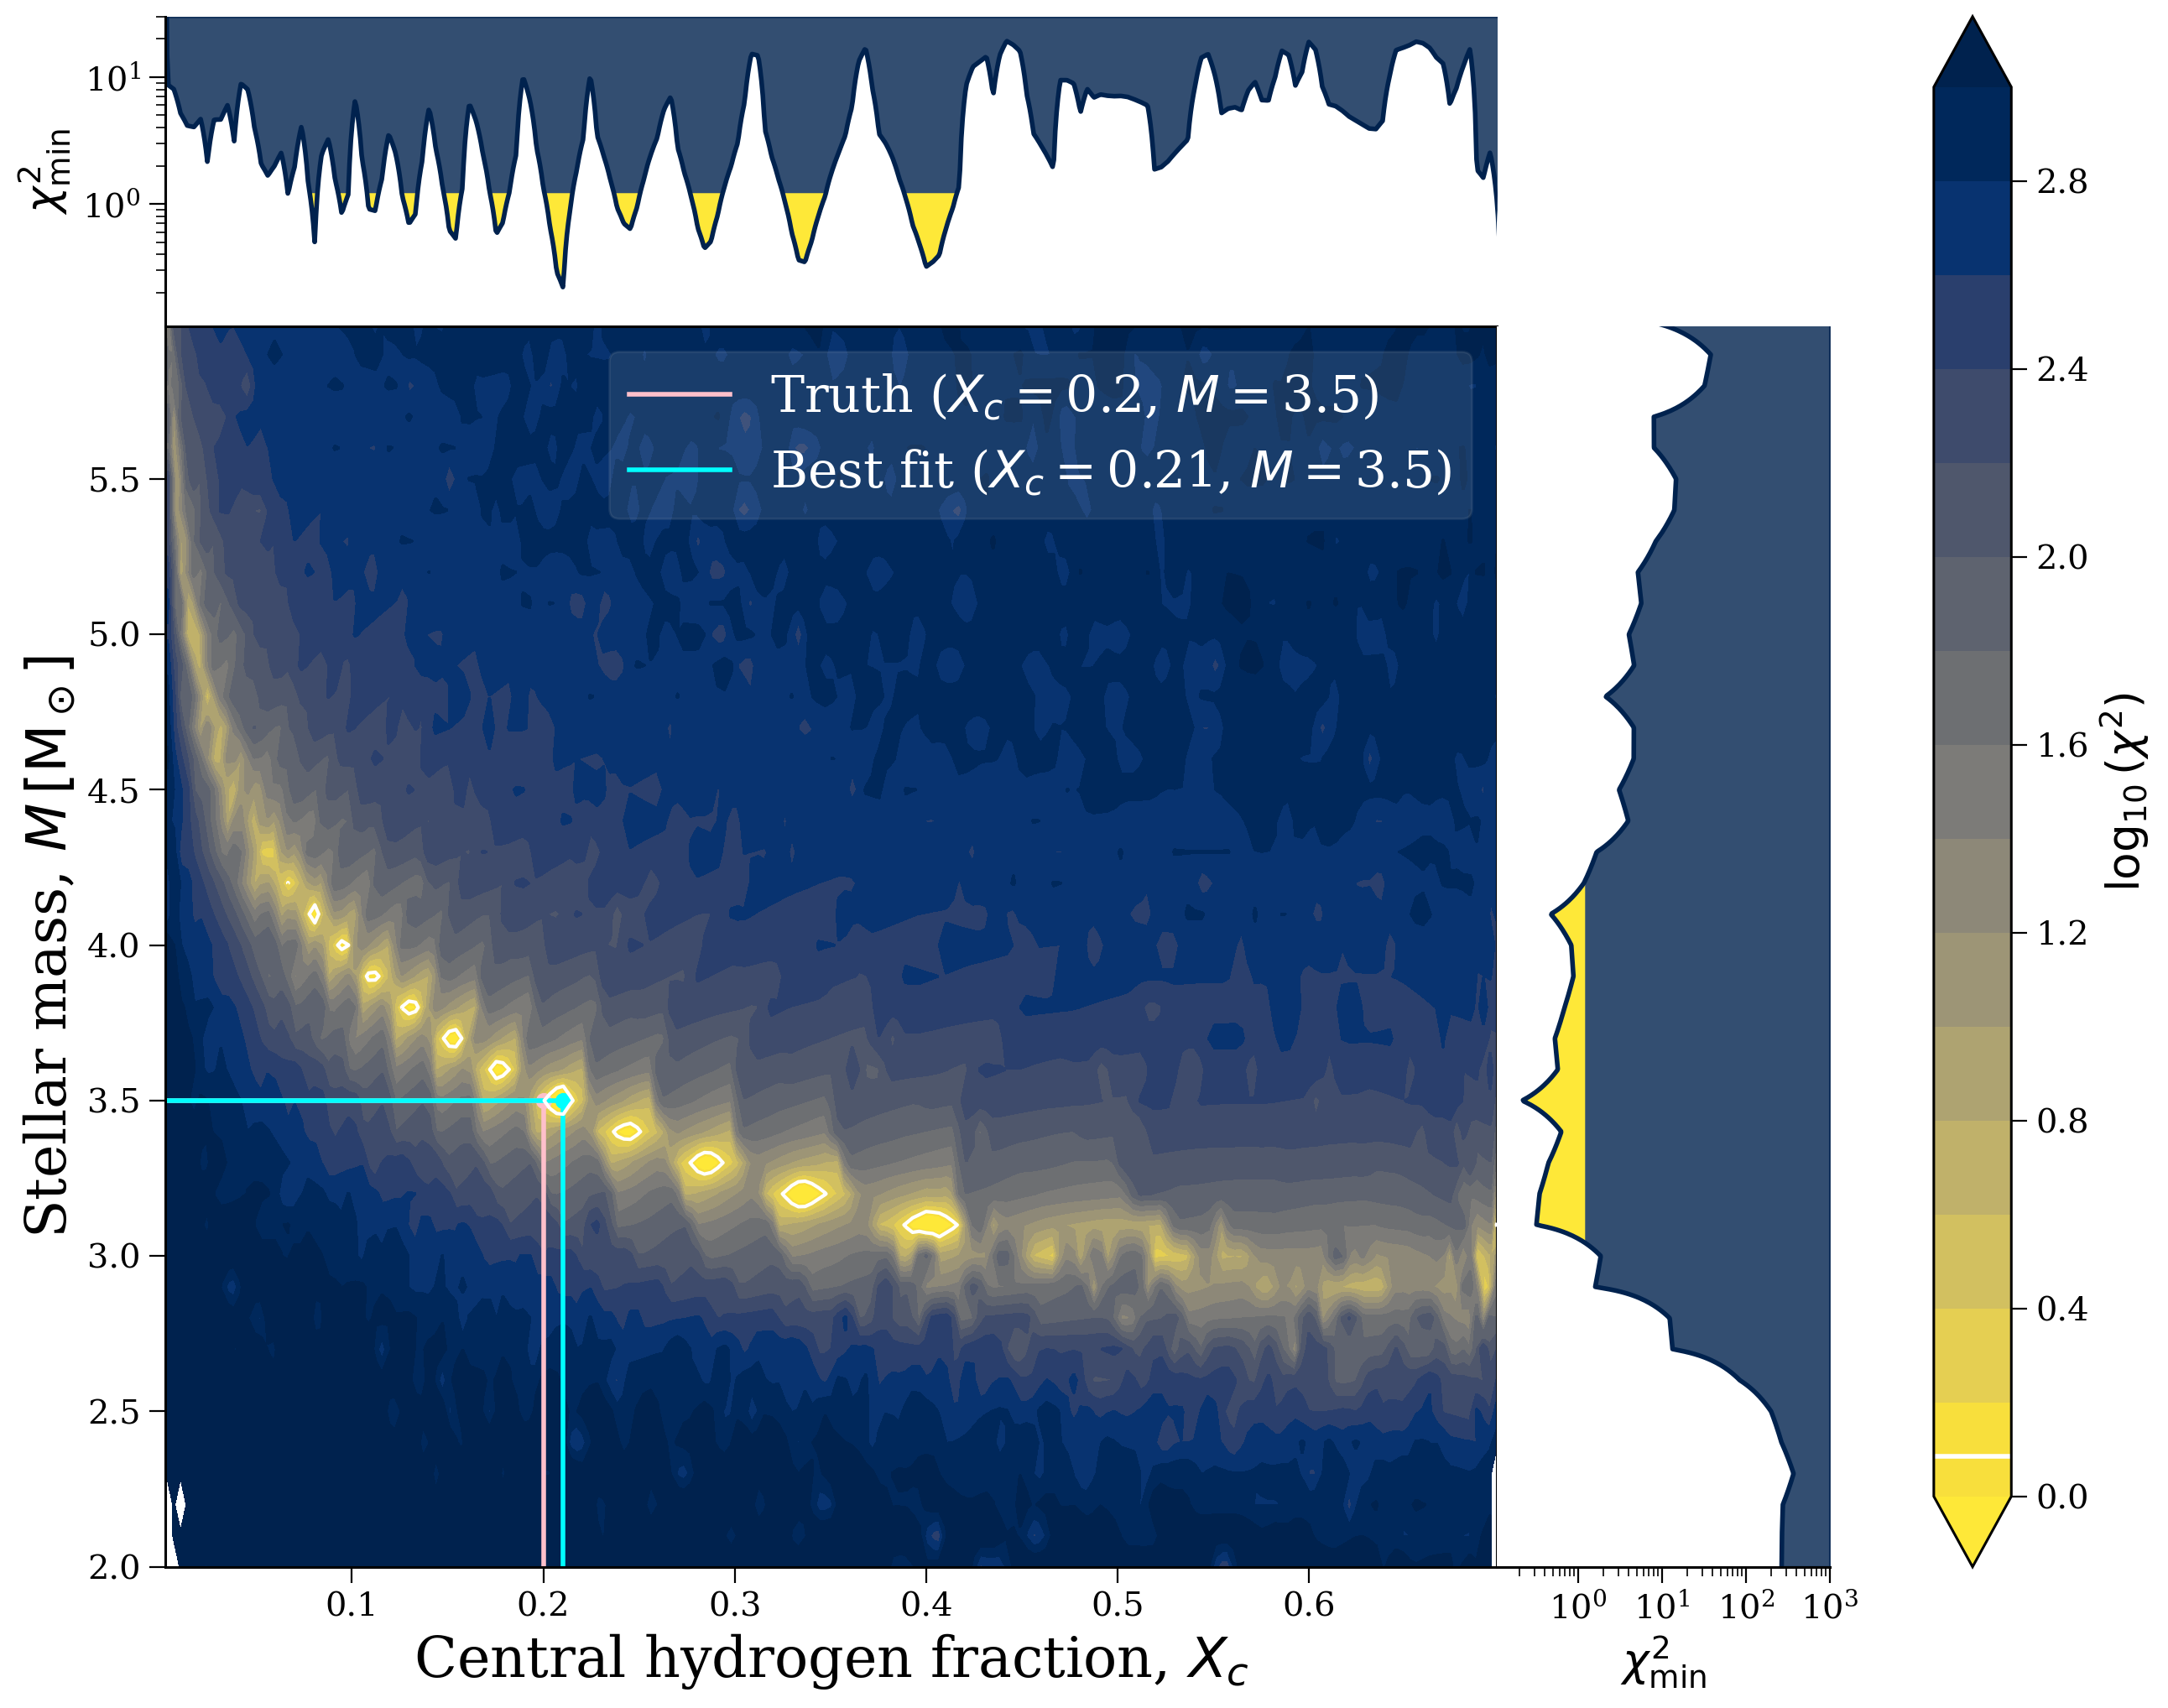

0.1 0.260 3.000


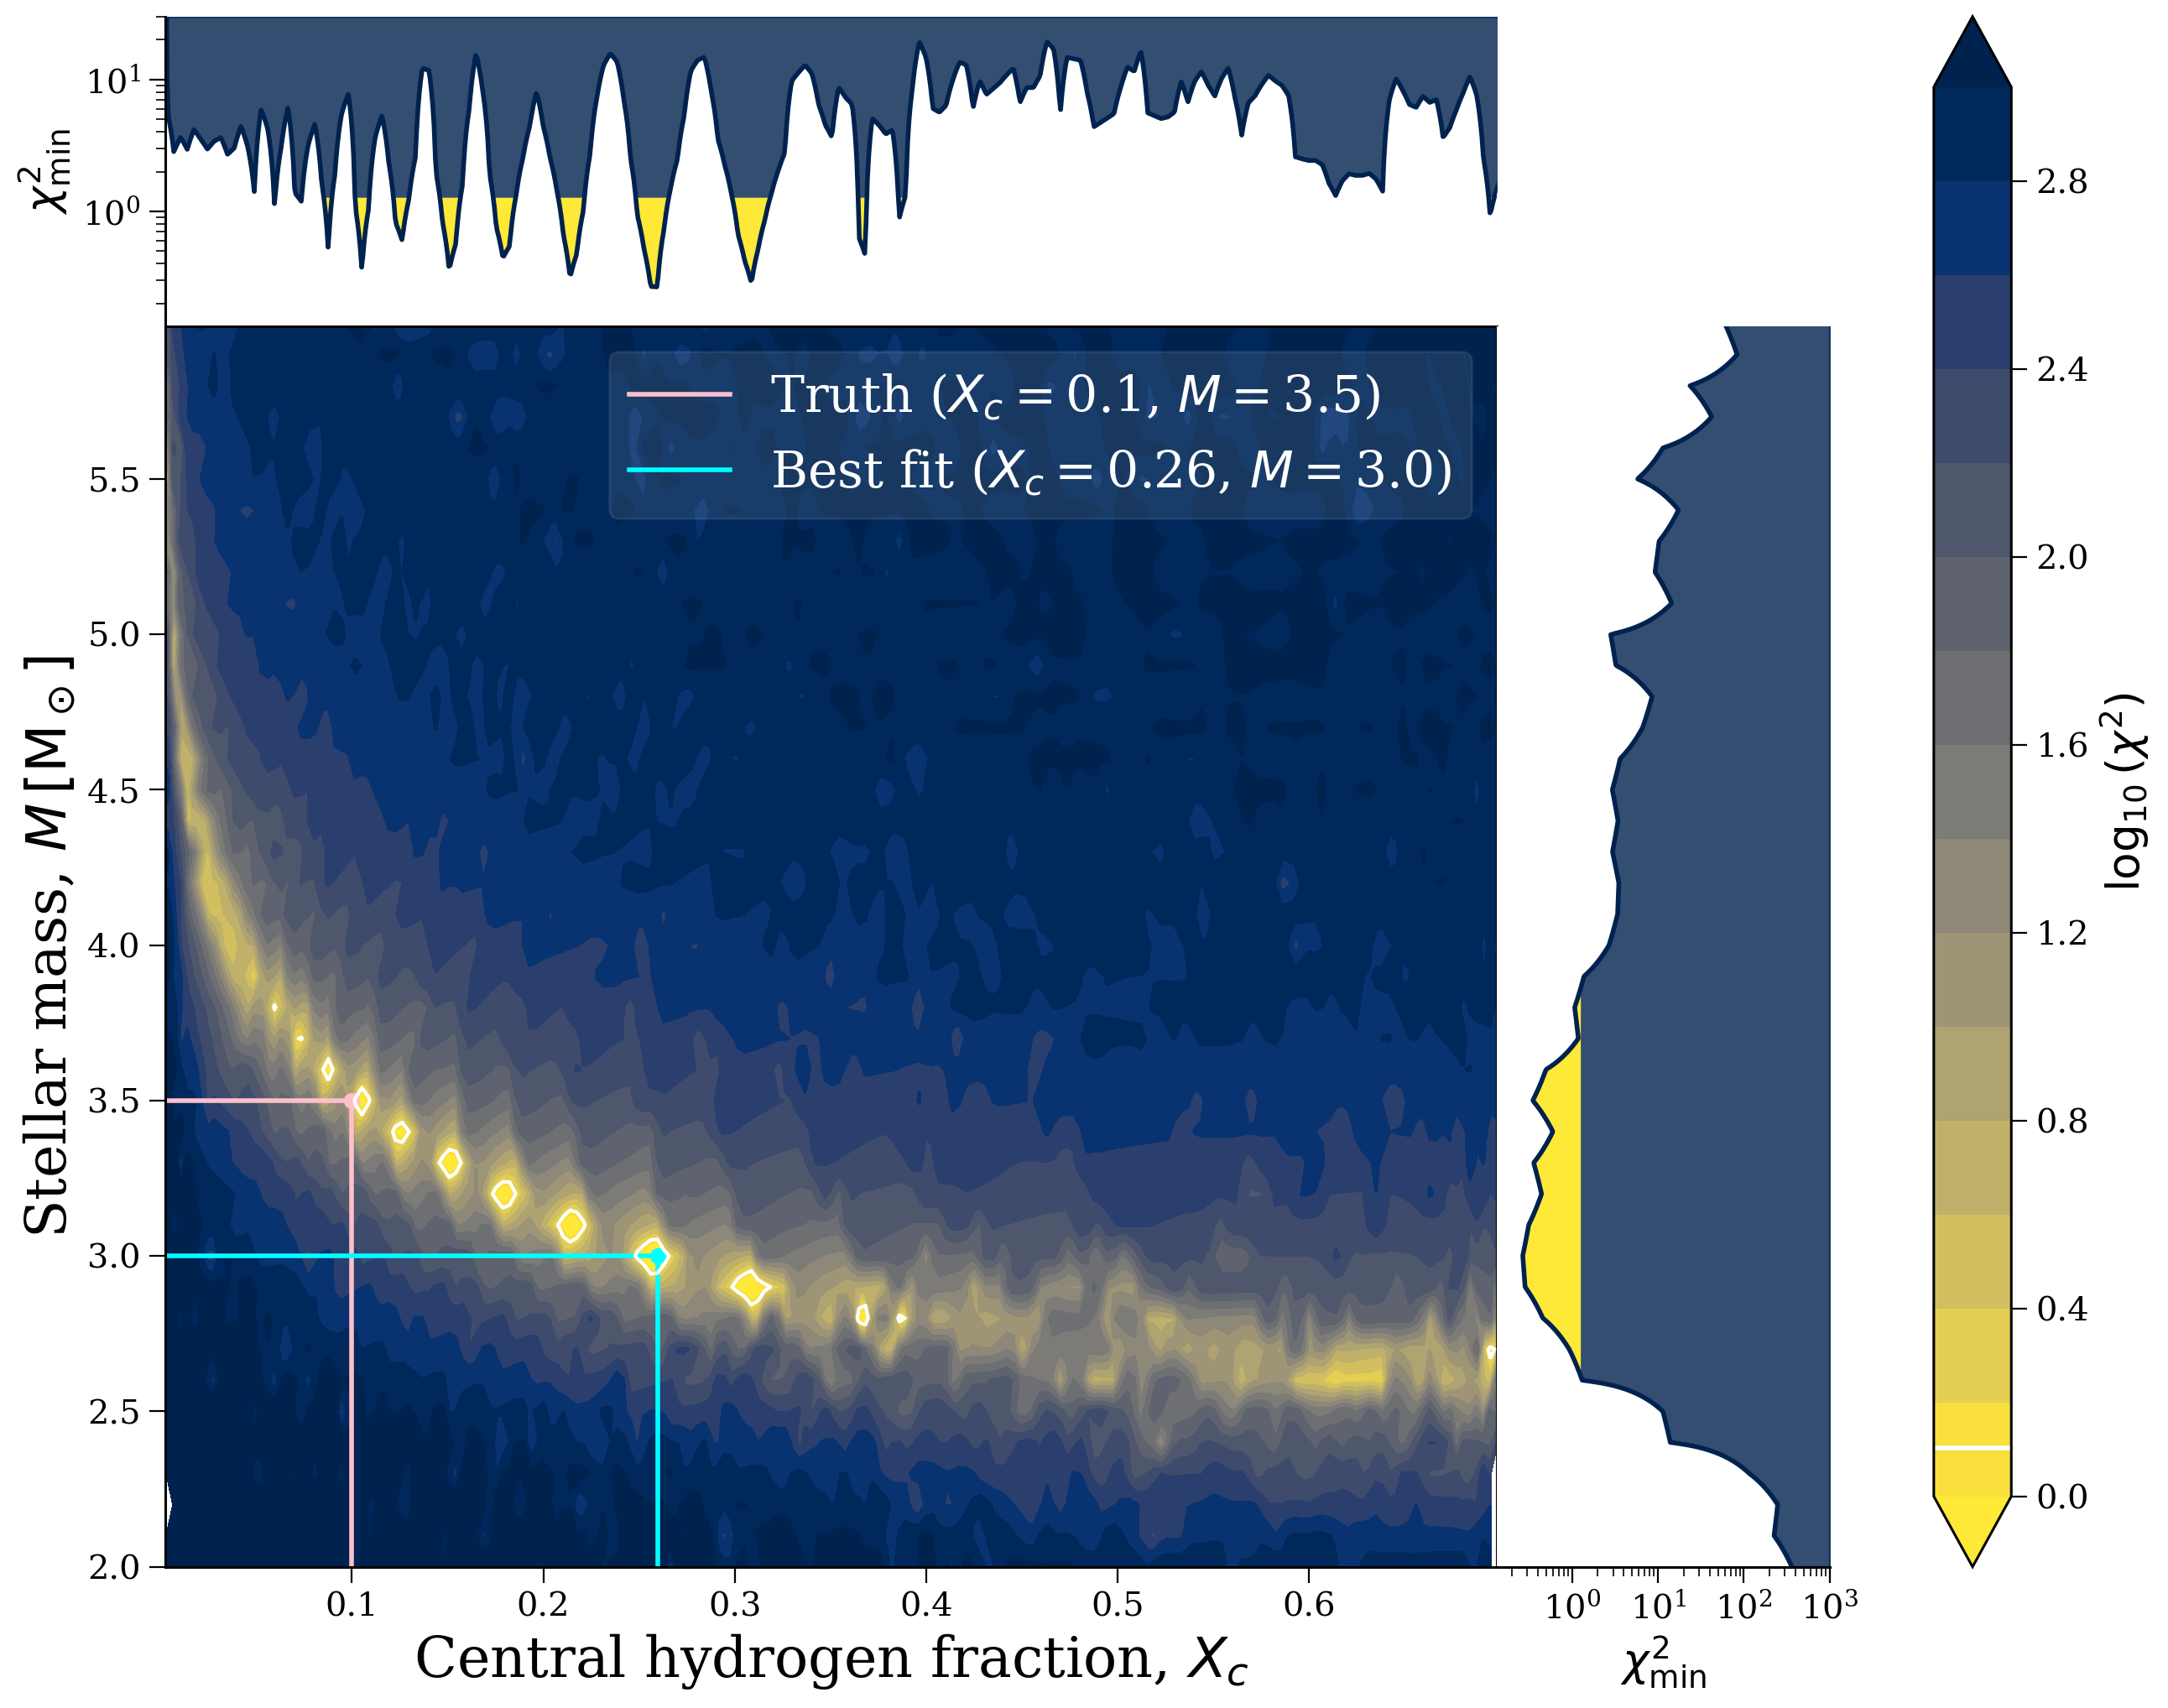

0.01 0.523 2.000


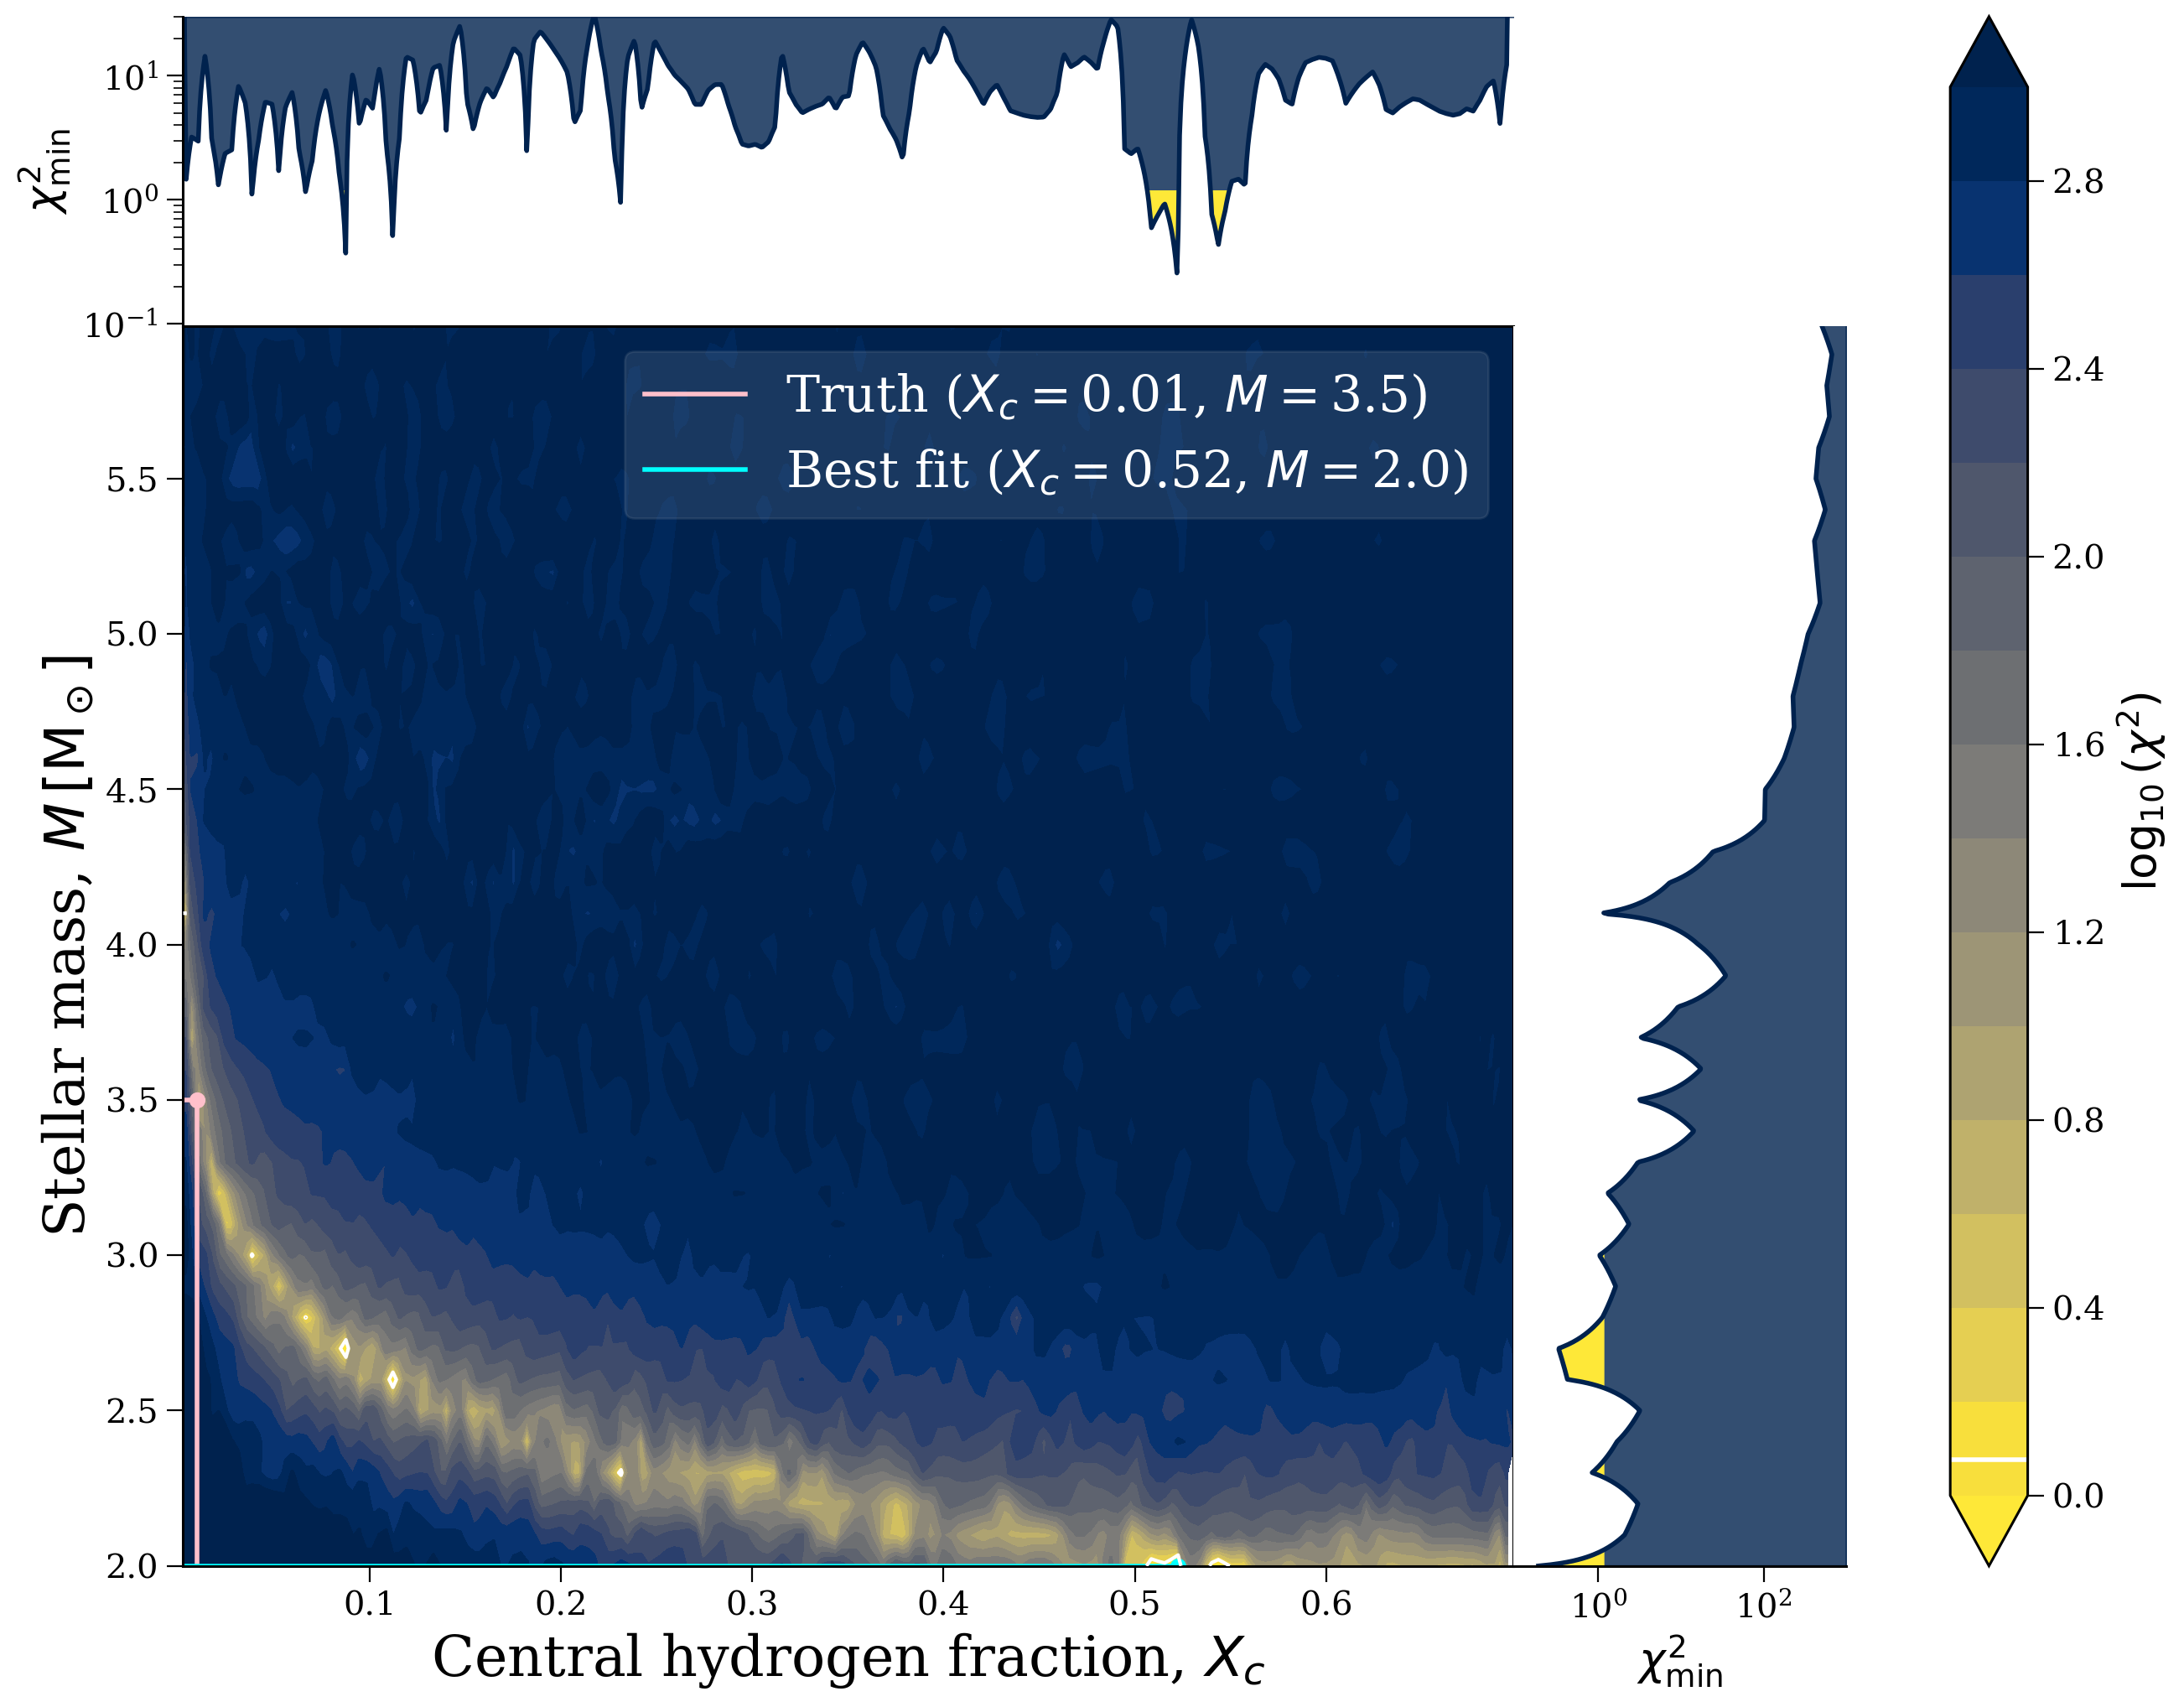

In [139]:
for X_c, chi in zip(X_c_range, chi_sigma_1):
    plot_chis(chis=chi, X_c=X_c, save=True, marginals=True)

# 2. Fit the asymptotic period spacing

In [313]:
def chi_asp(p_s, p_mg=None, x=None, p_min=1.0, p_max=3.0):
    # if x is not directly supplied then compute it
    if x is None:
        # sort mass-gainer periods, remove units, limit period range
        p_mg = np.sort(p_mg.to(u.d).value)
        p_mg = p_mg[(p_mg > p_min) & (p_mg <= p_max)]
    else:
        p_mg = x

    # sort single star periods, remove units, limit period range
    p_s = np.sort(p_s.to(u.d).value)
    p_s = p_s[(p_s > p_min) & (p_s <= p_max)]

    # convert to frequency and back to period with uncertainties
    f_mg = 1 / p_mg
    f_mg_with_unc = unumpy.uarray(f_mg, np.ones(len(f_mg)) / 1150)
    p_mg_with_unc = 1 / f_mg_with_unc
    asp_with_unc = np.diff(p_mg_with_unc).mean()
    sigma = asp_with_unc.s
    asp = asp_with_unc.n

    return (np.diff(p_s).mean() - asp)**2 / sigma**2

In [309]:
def get_all_chi_asps(X_c=0.1, **kwargs):
    p_mg, _, _ = mpt.get_delta_p(track, X_c=X_c)
    p_mg = np.sort(p_mg.to(u.d).value)
    x = p_mg[(p_mg > 1.0) & (p_mg <= 3.0)]
    
    return [[chi_asp(p_s=mpt.get_delta_p(single_tracks[mod_name], mod=i)[0], x=x, **kwargs)
             for i in range(len(single_tracks[mod_name].freqs))] for mod_name in mod_names]

In [319]:
chis_from_asp = [get_all_chi_asps(X_c=X_c) for X_c in X_c_range]

0.47 0.547 3.500


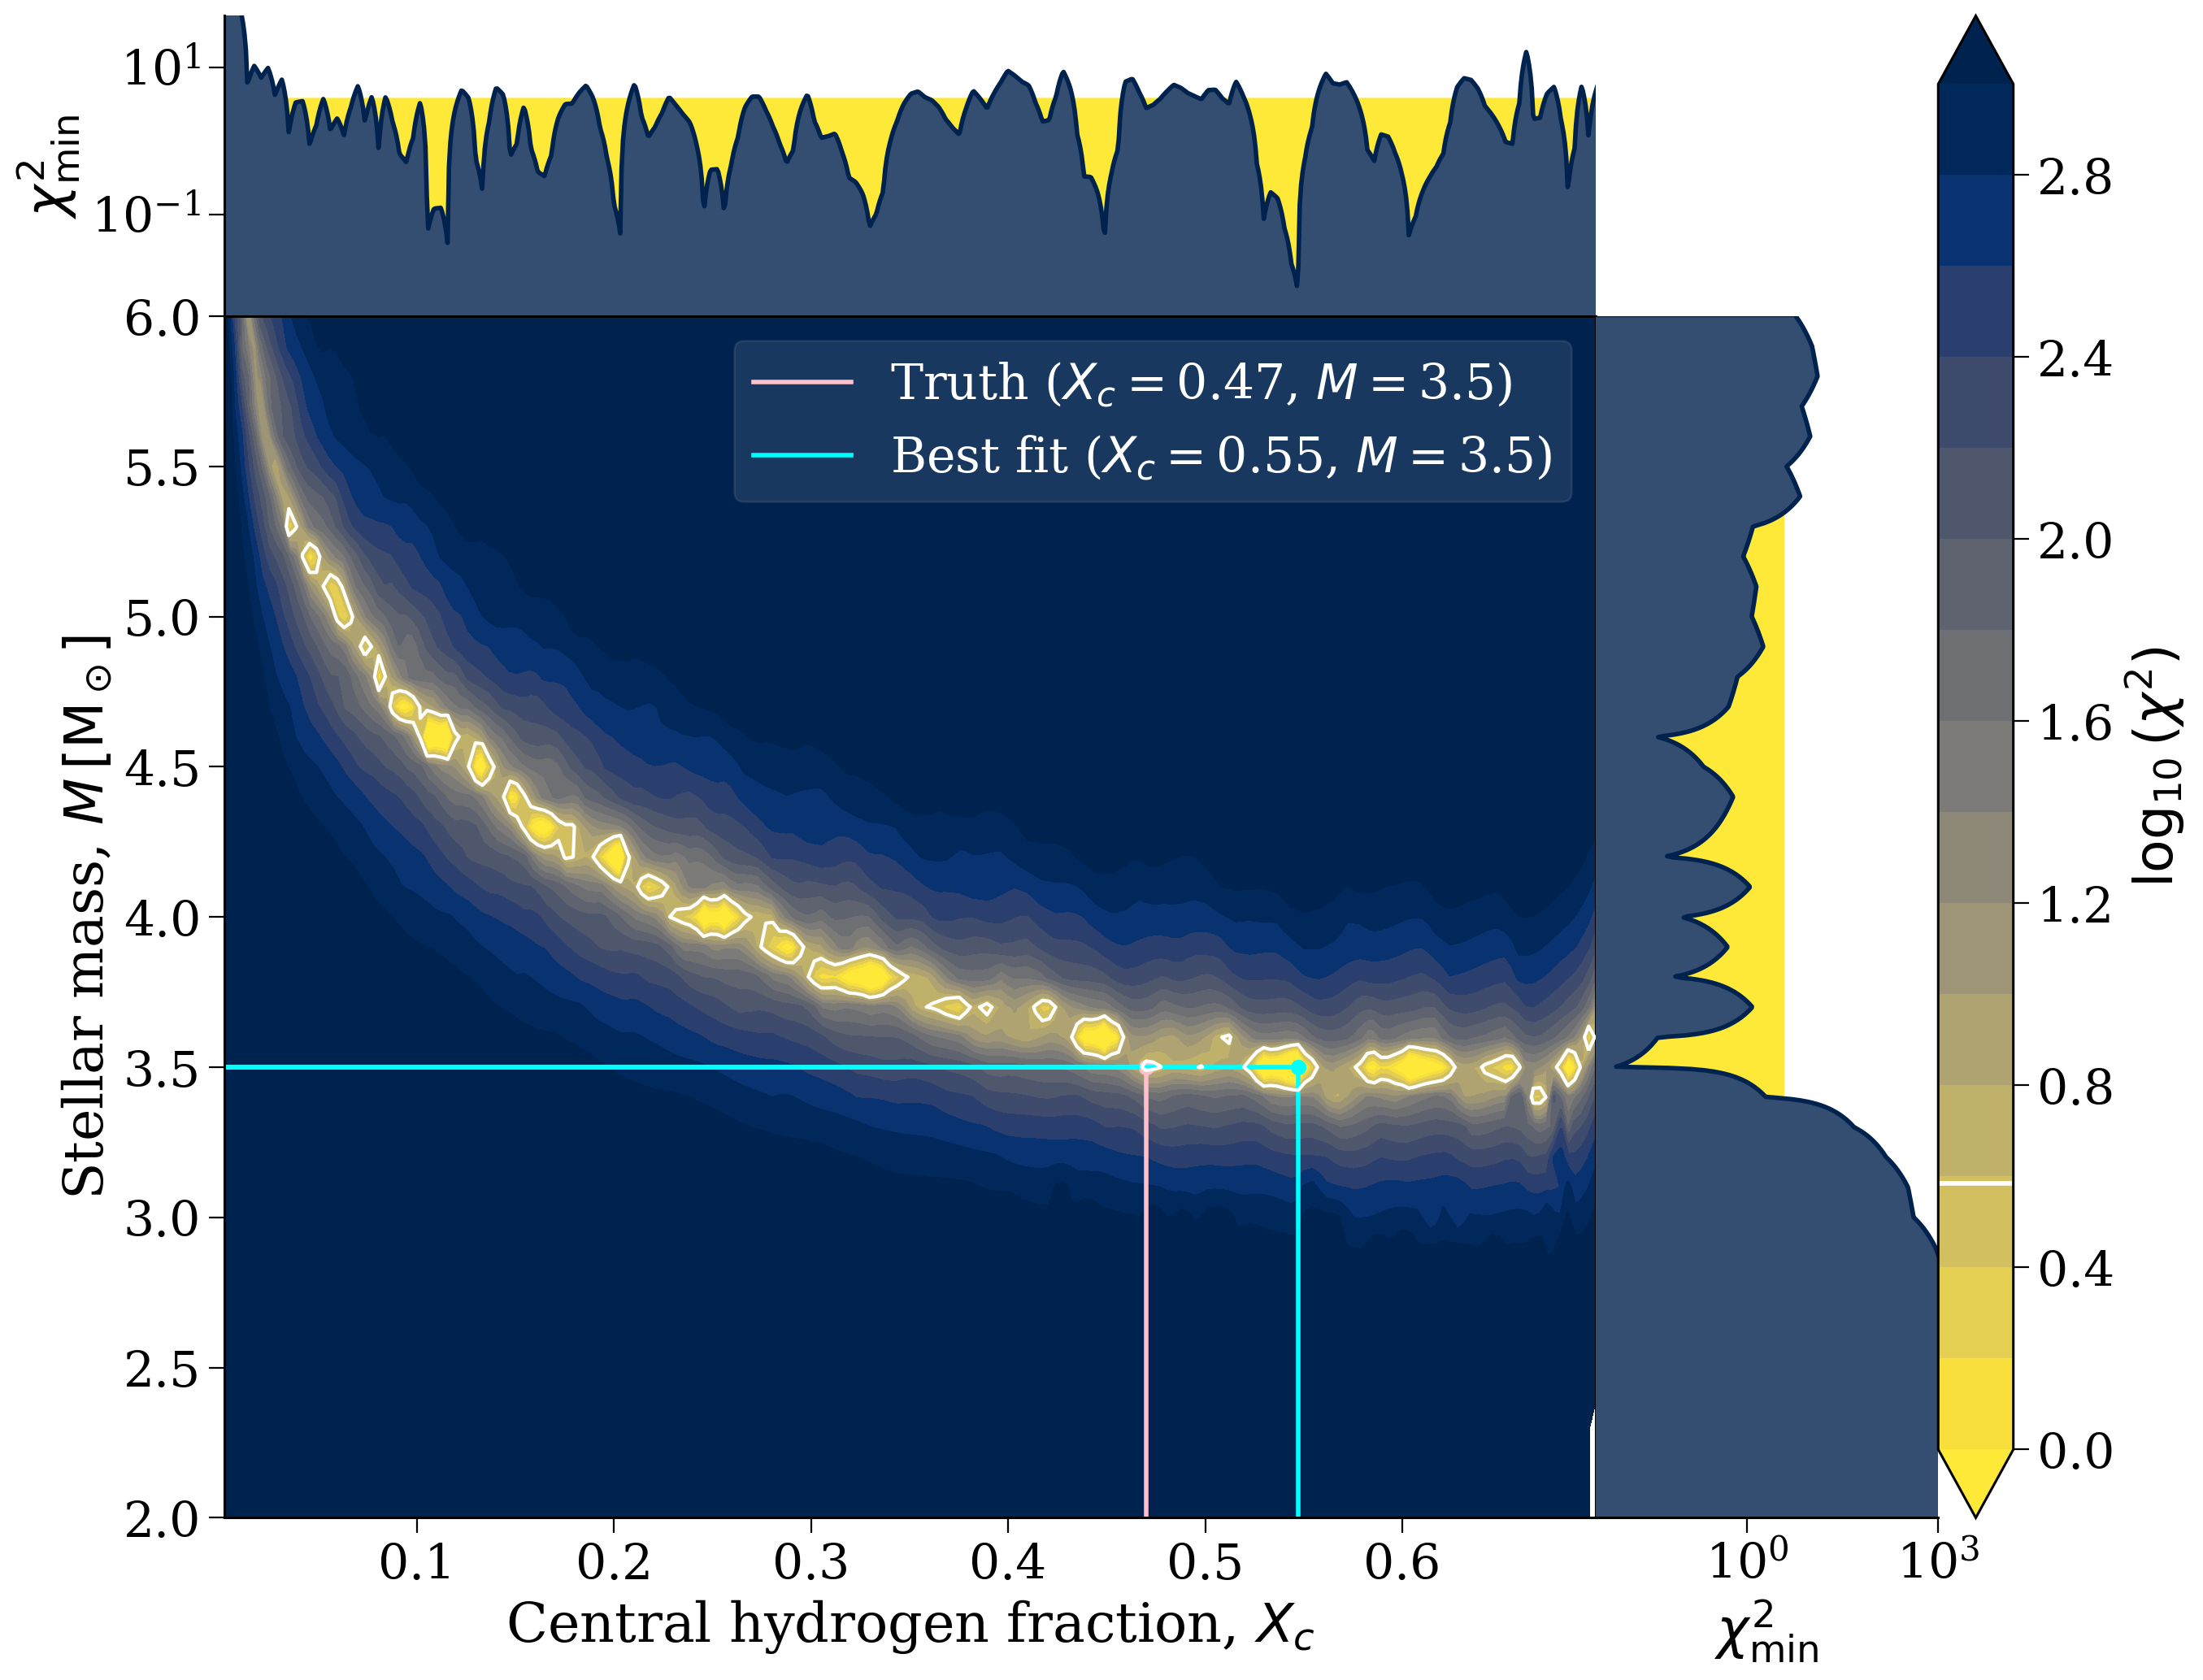

0.4 0.698 3.500


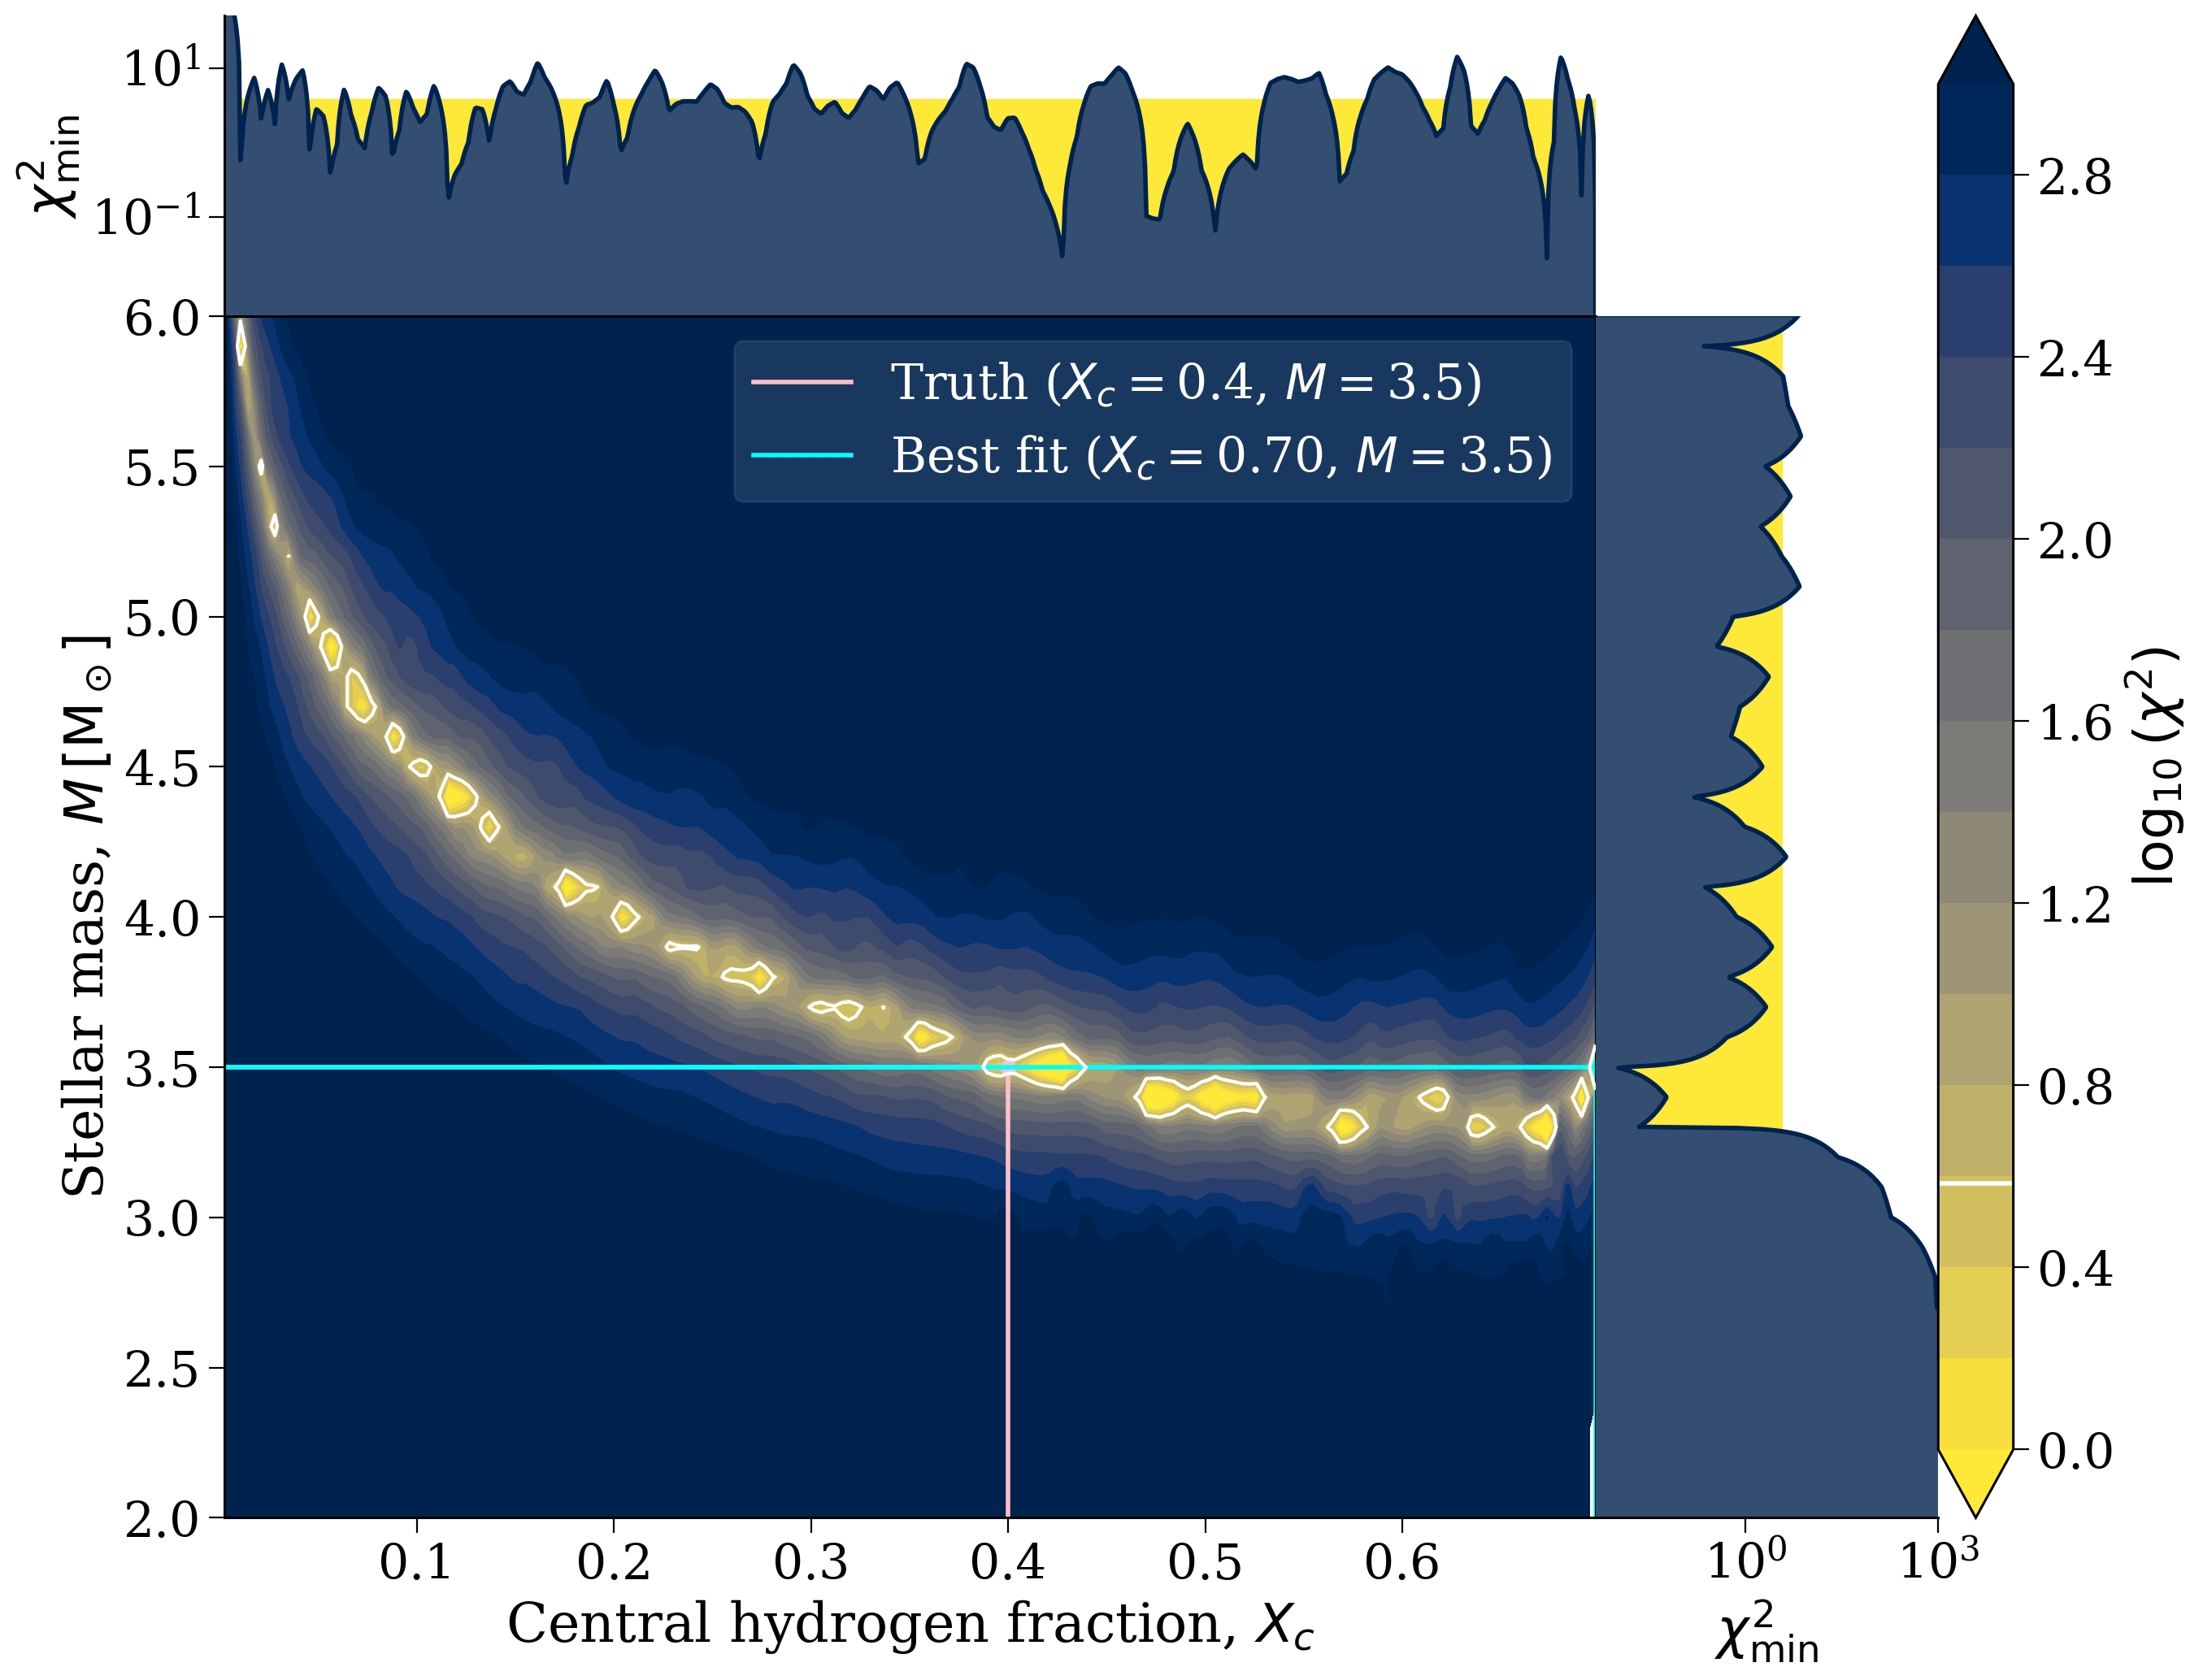

0.3 0.210 3.800


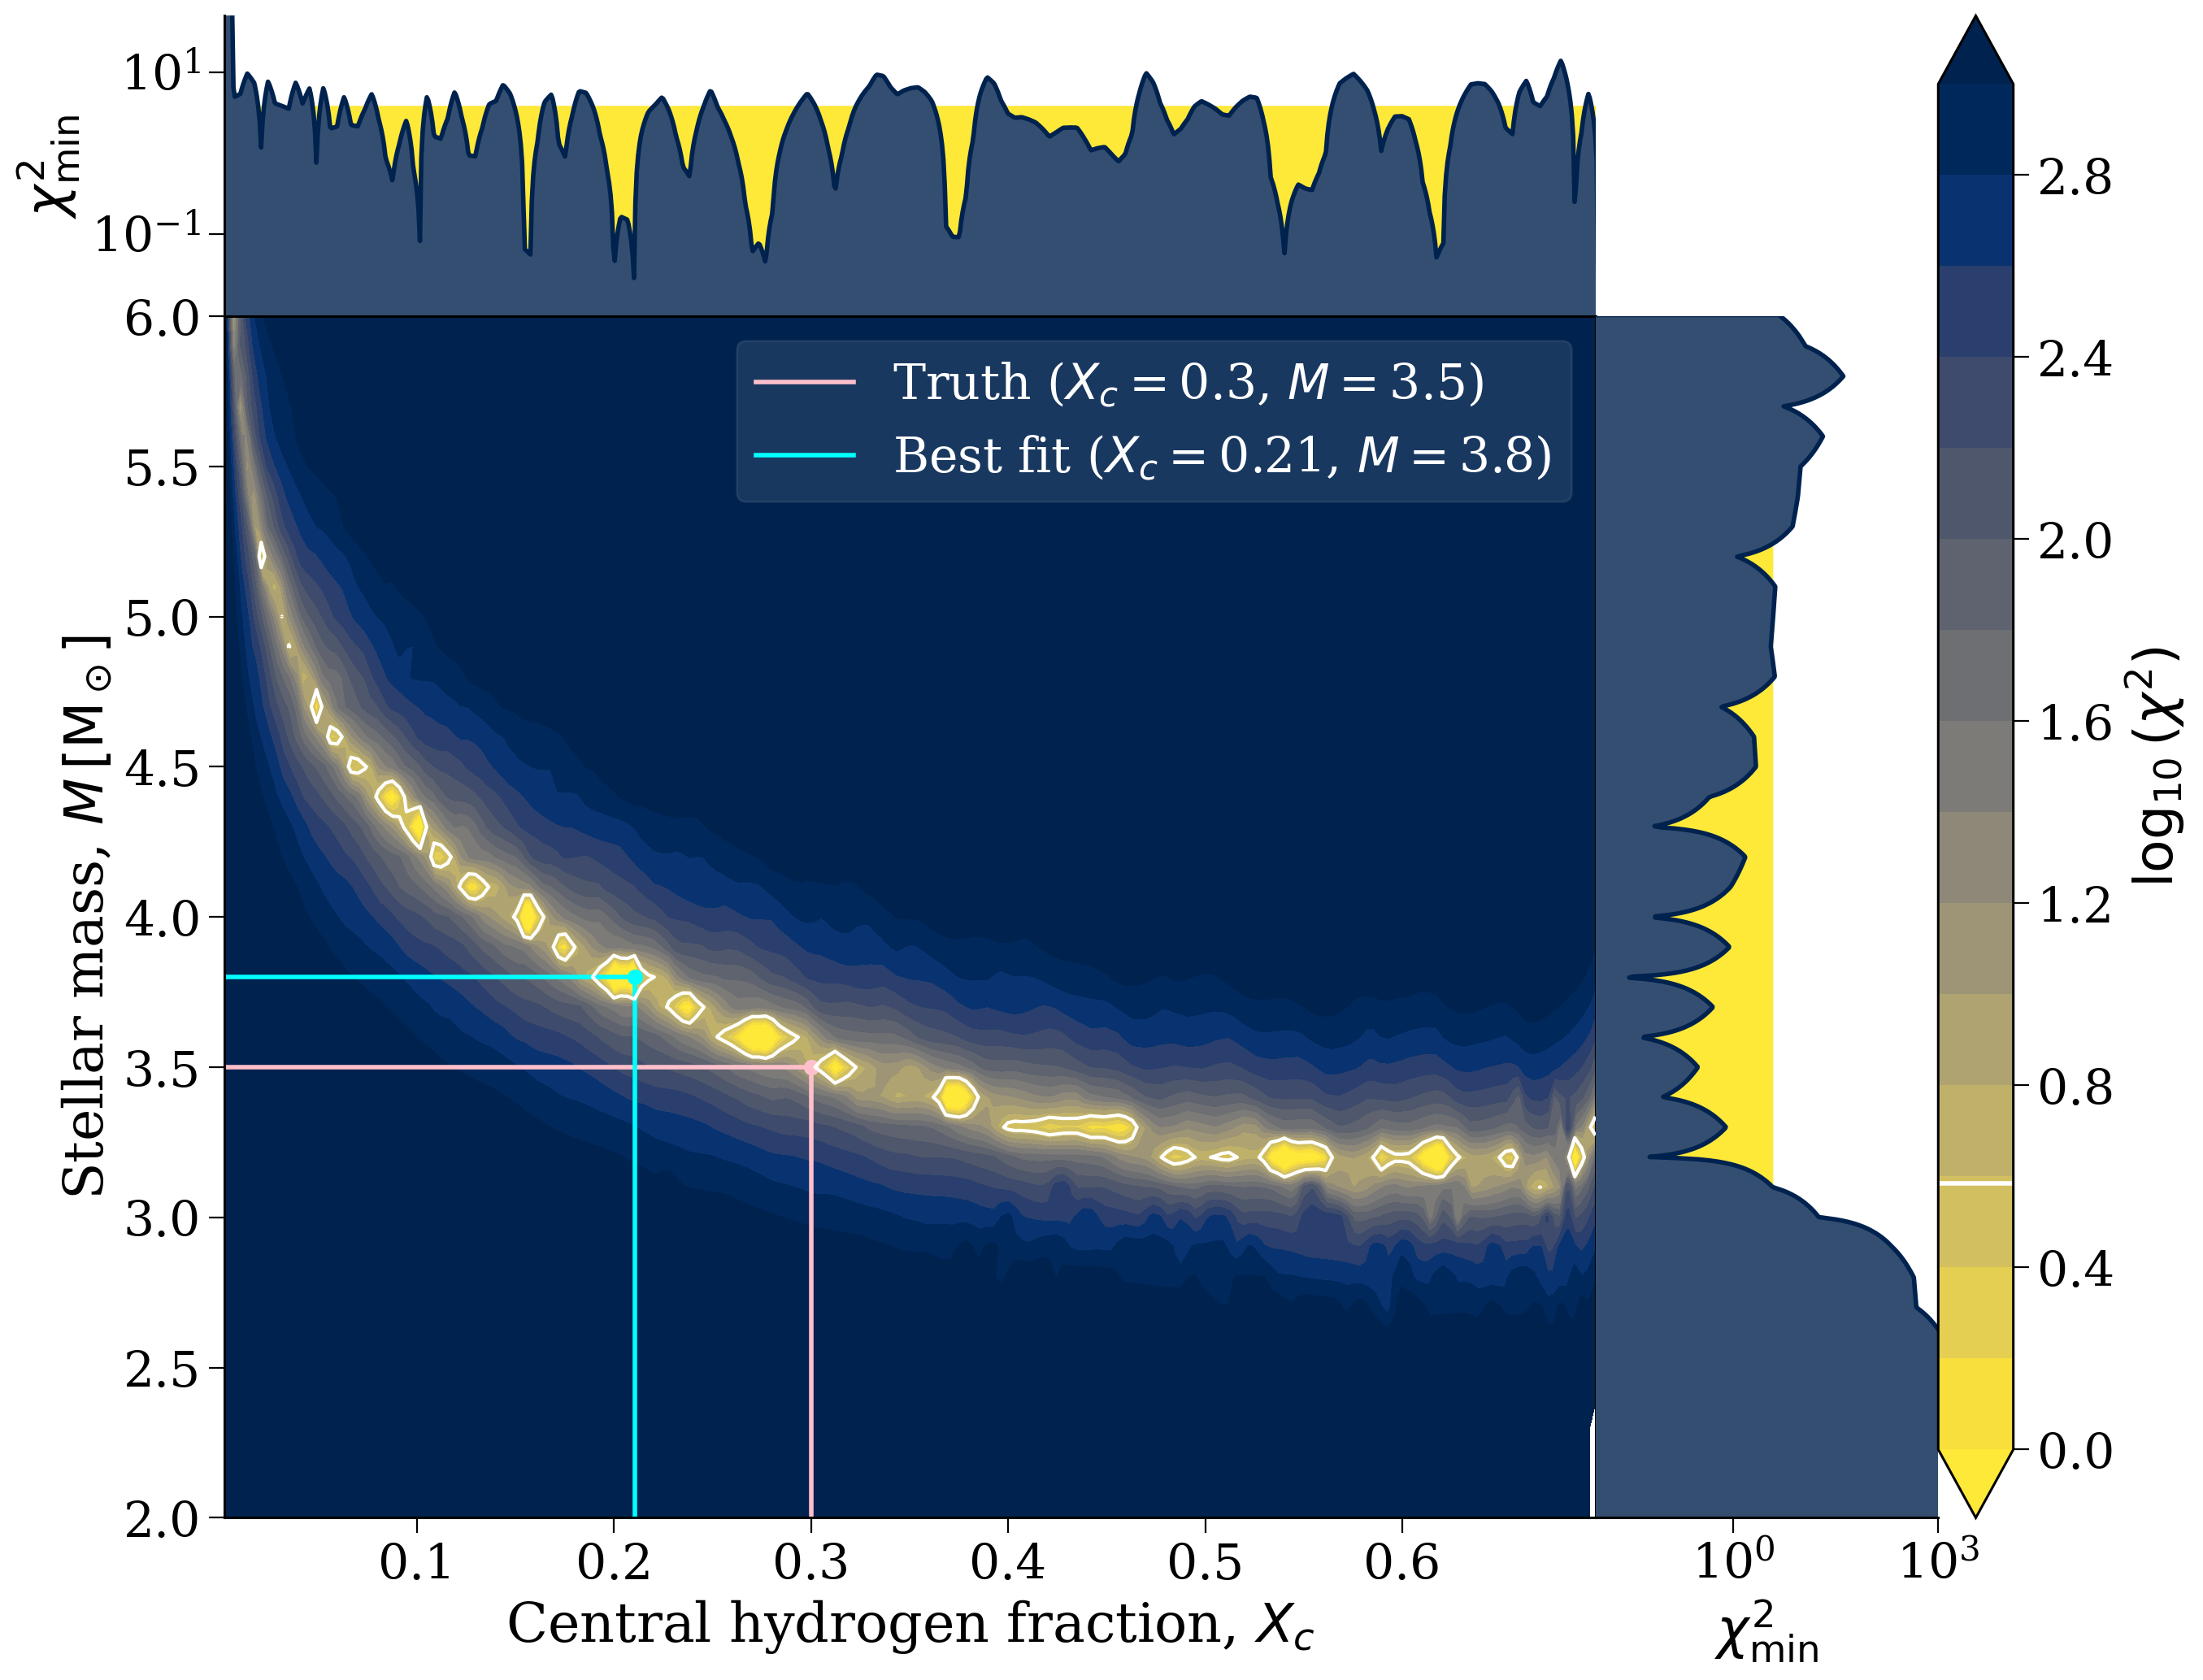

0.2 0.288 3.300


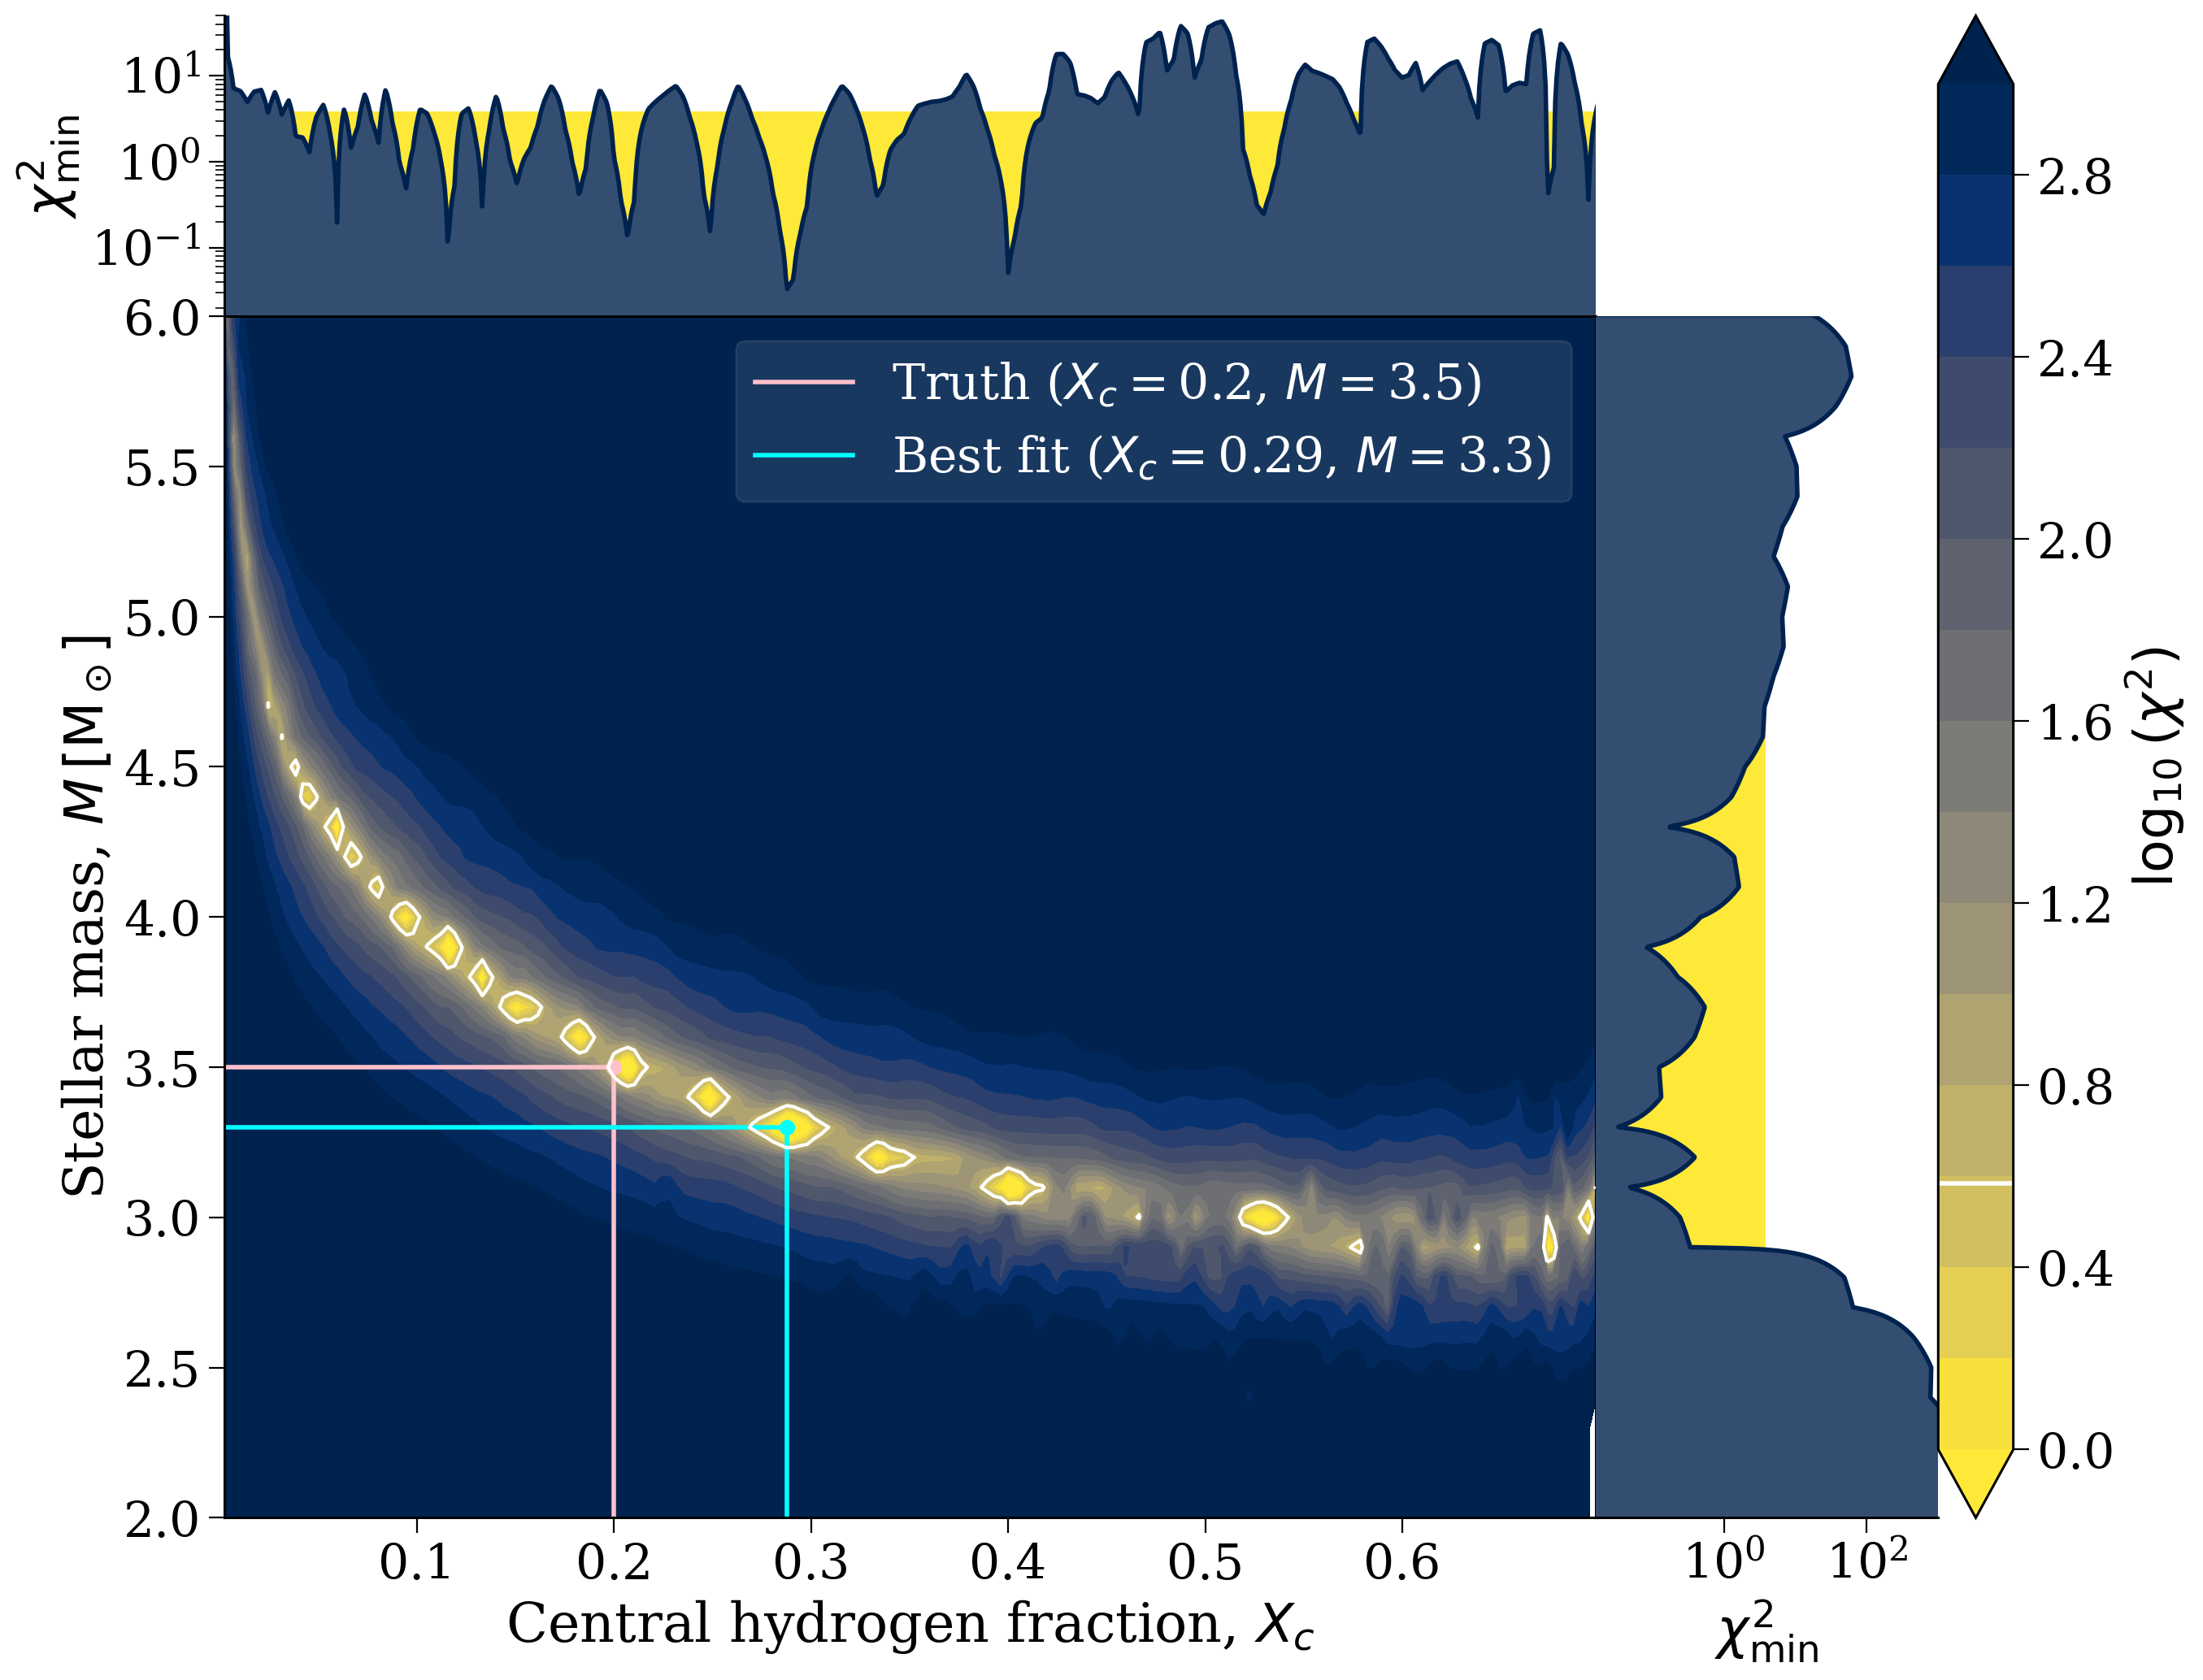

0.1 0.088 3.600


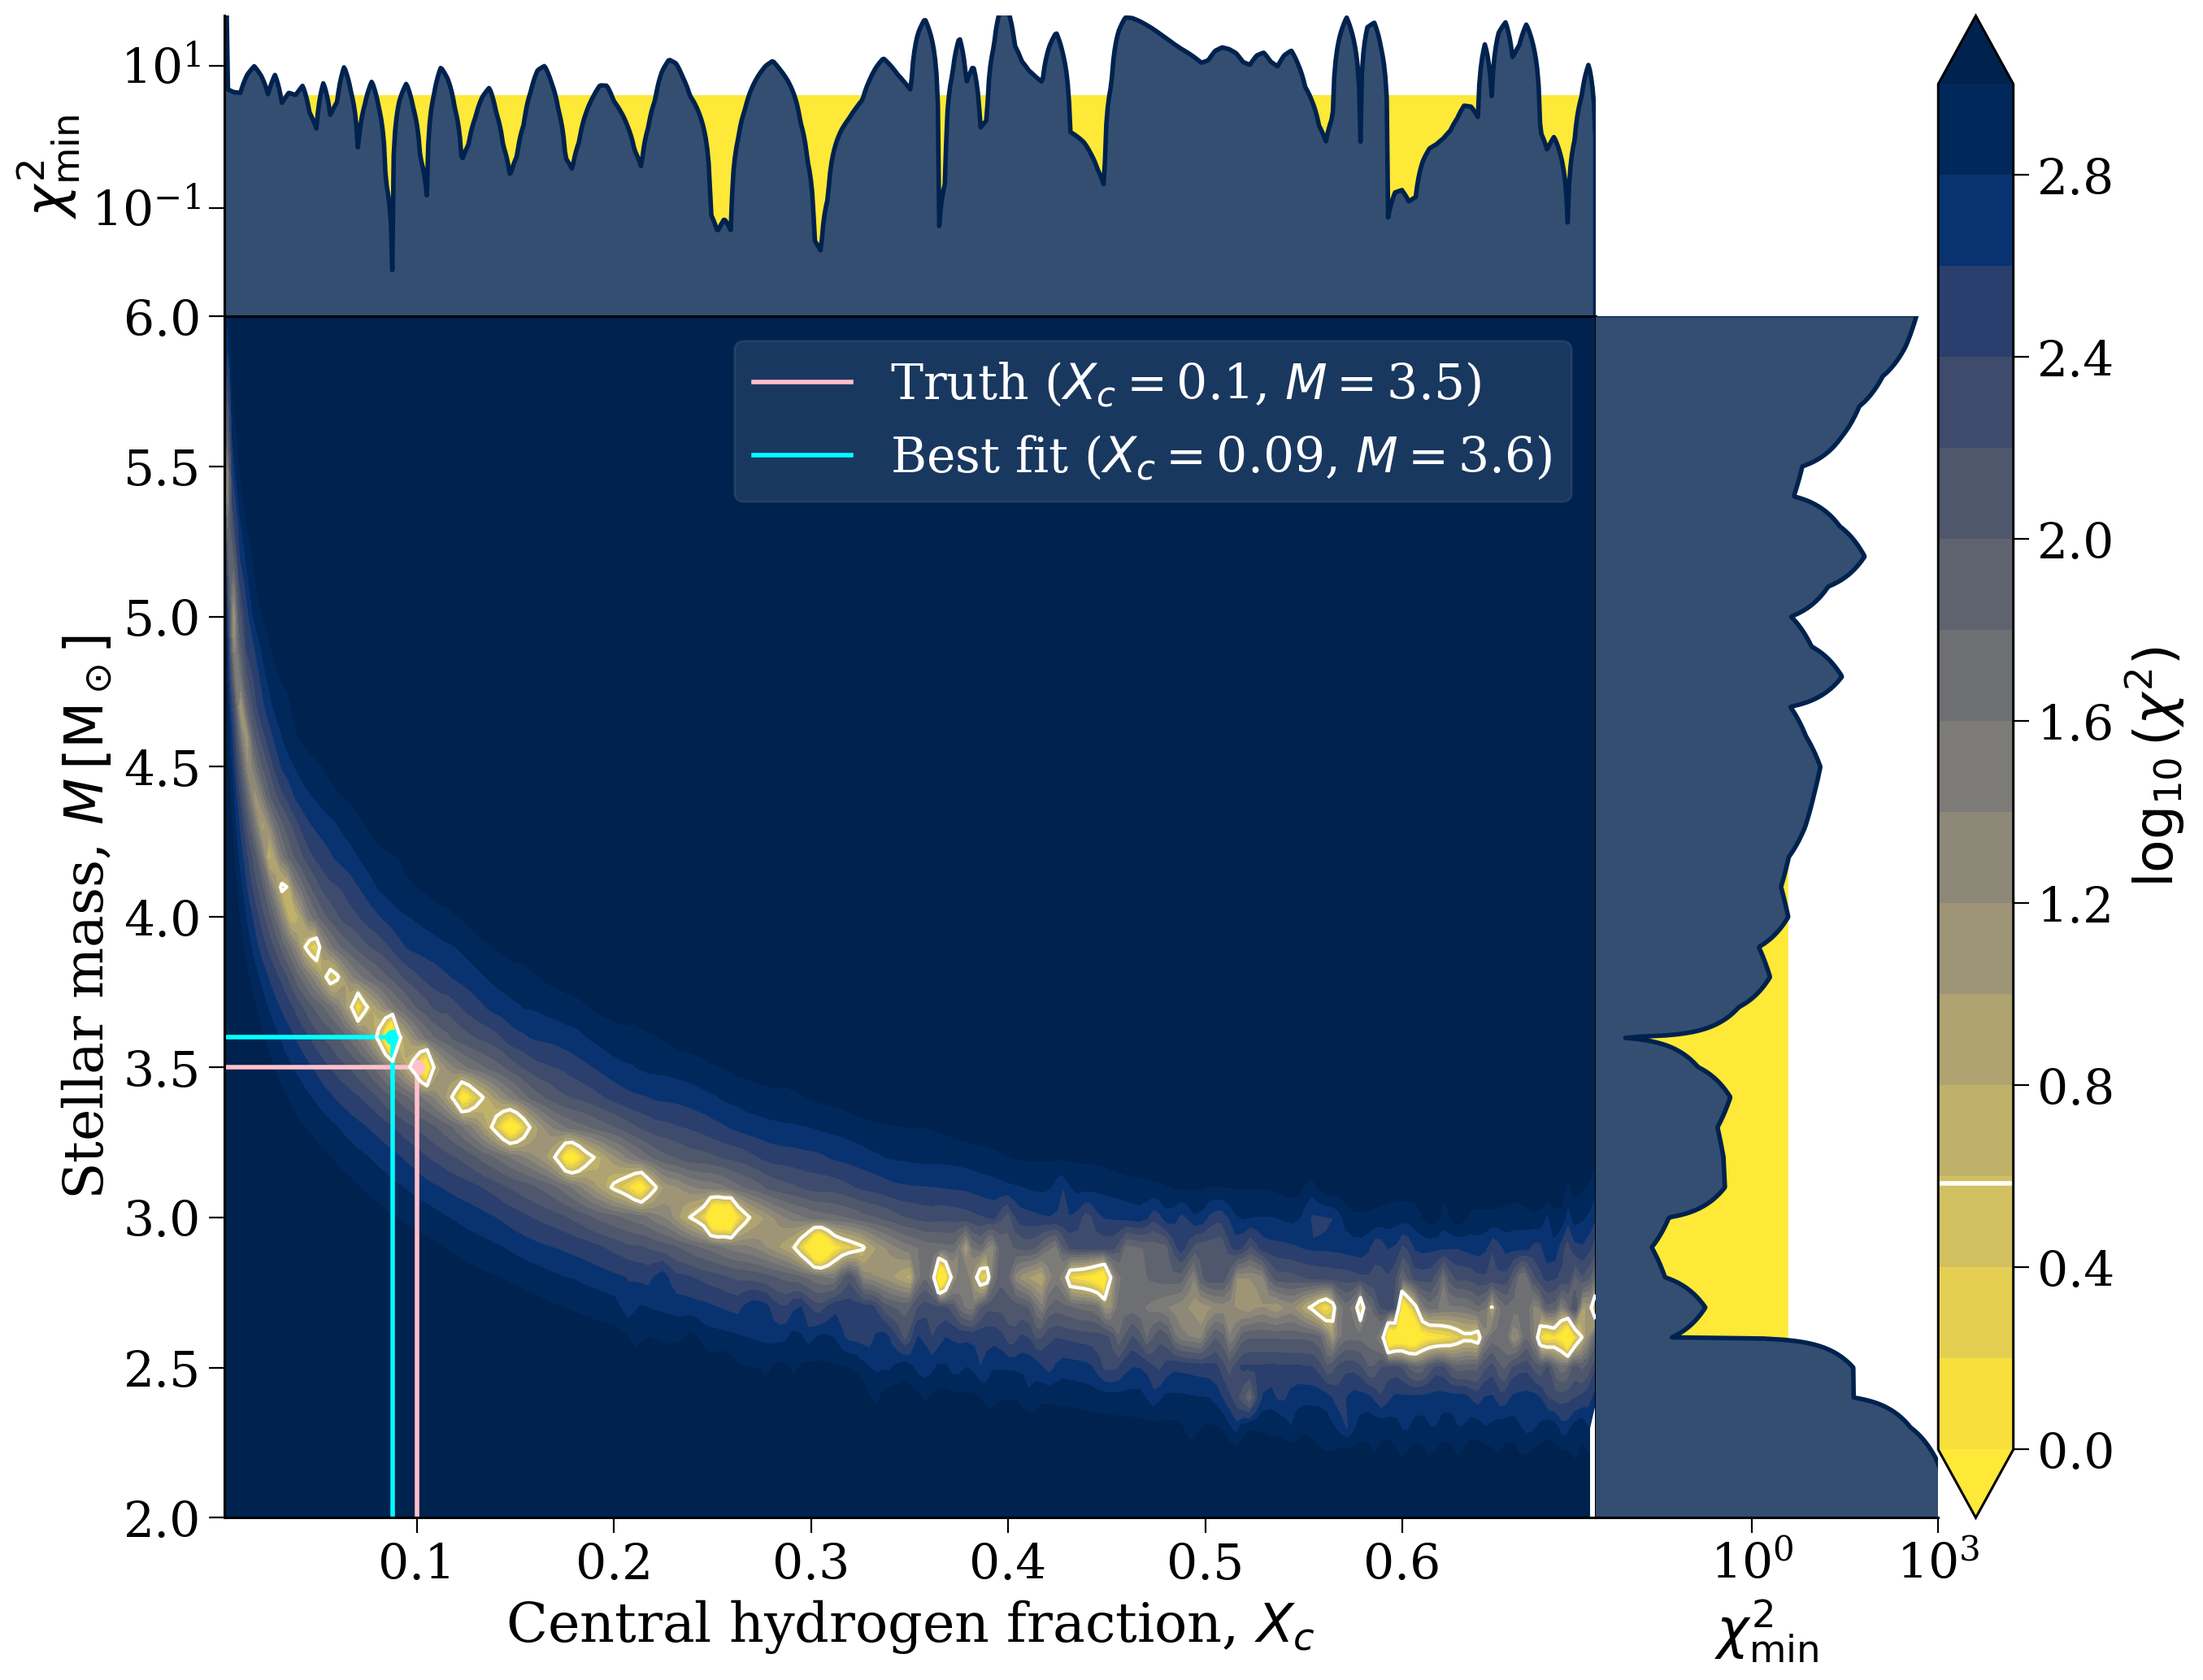

0.01 0.452 2.100


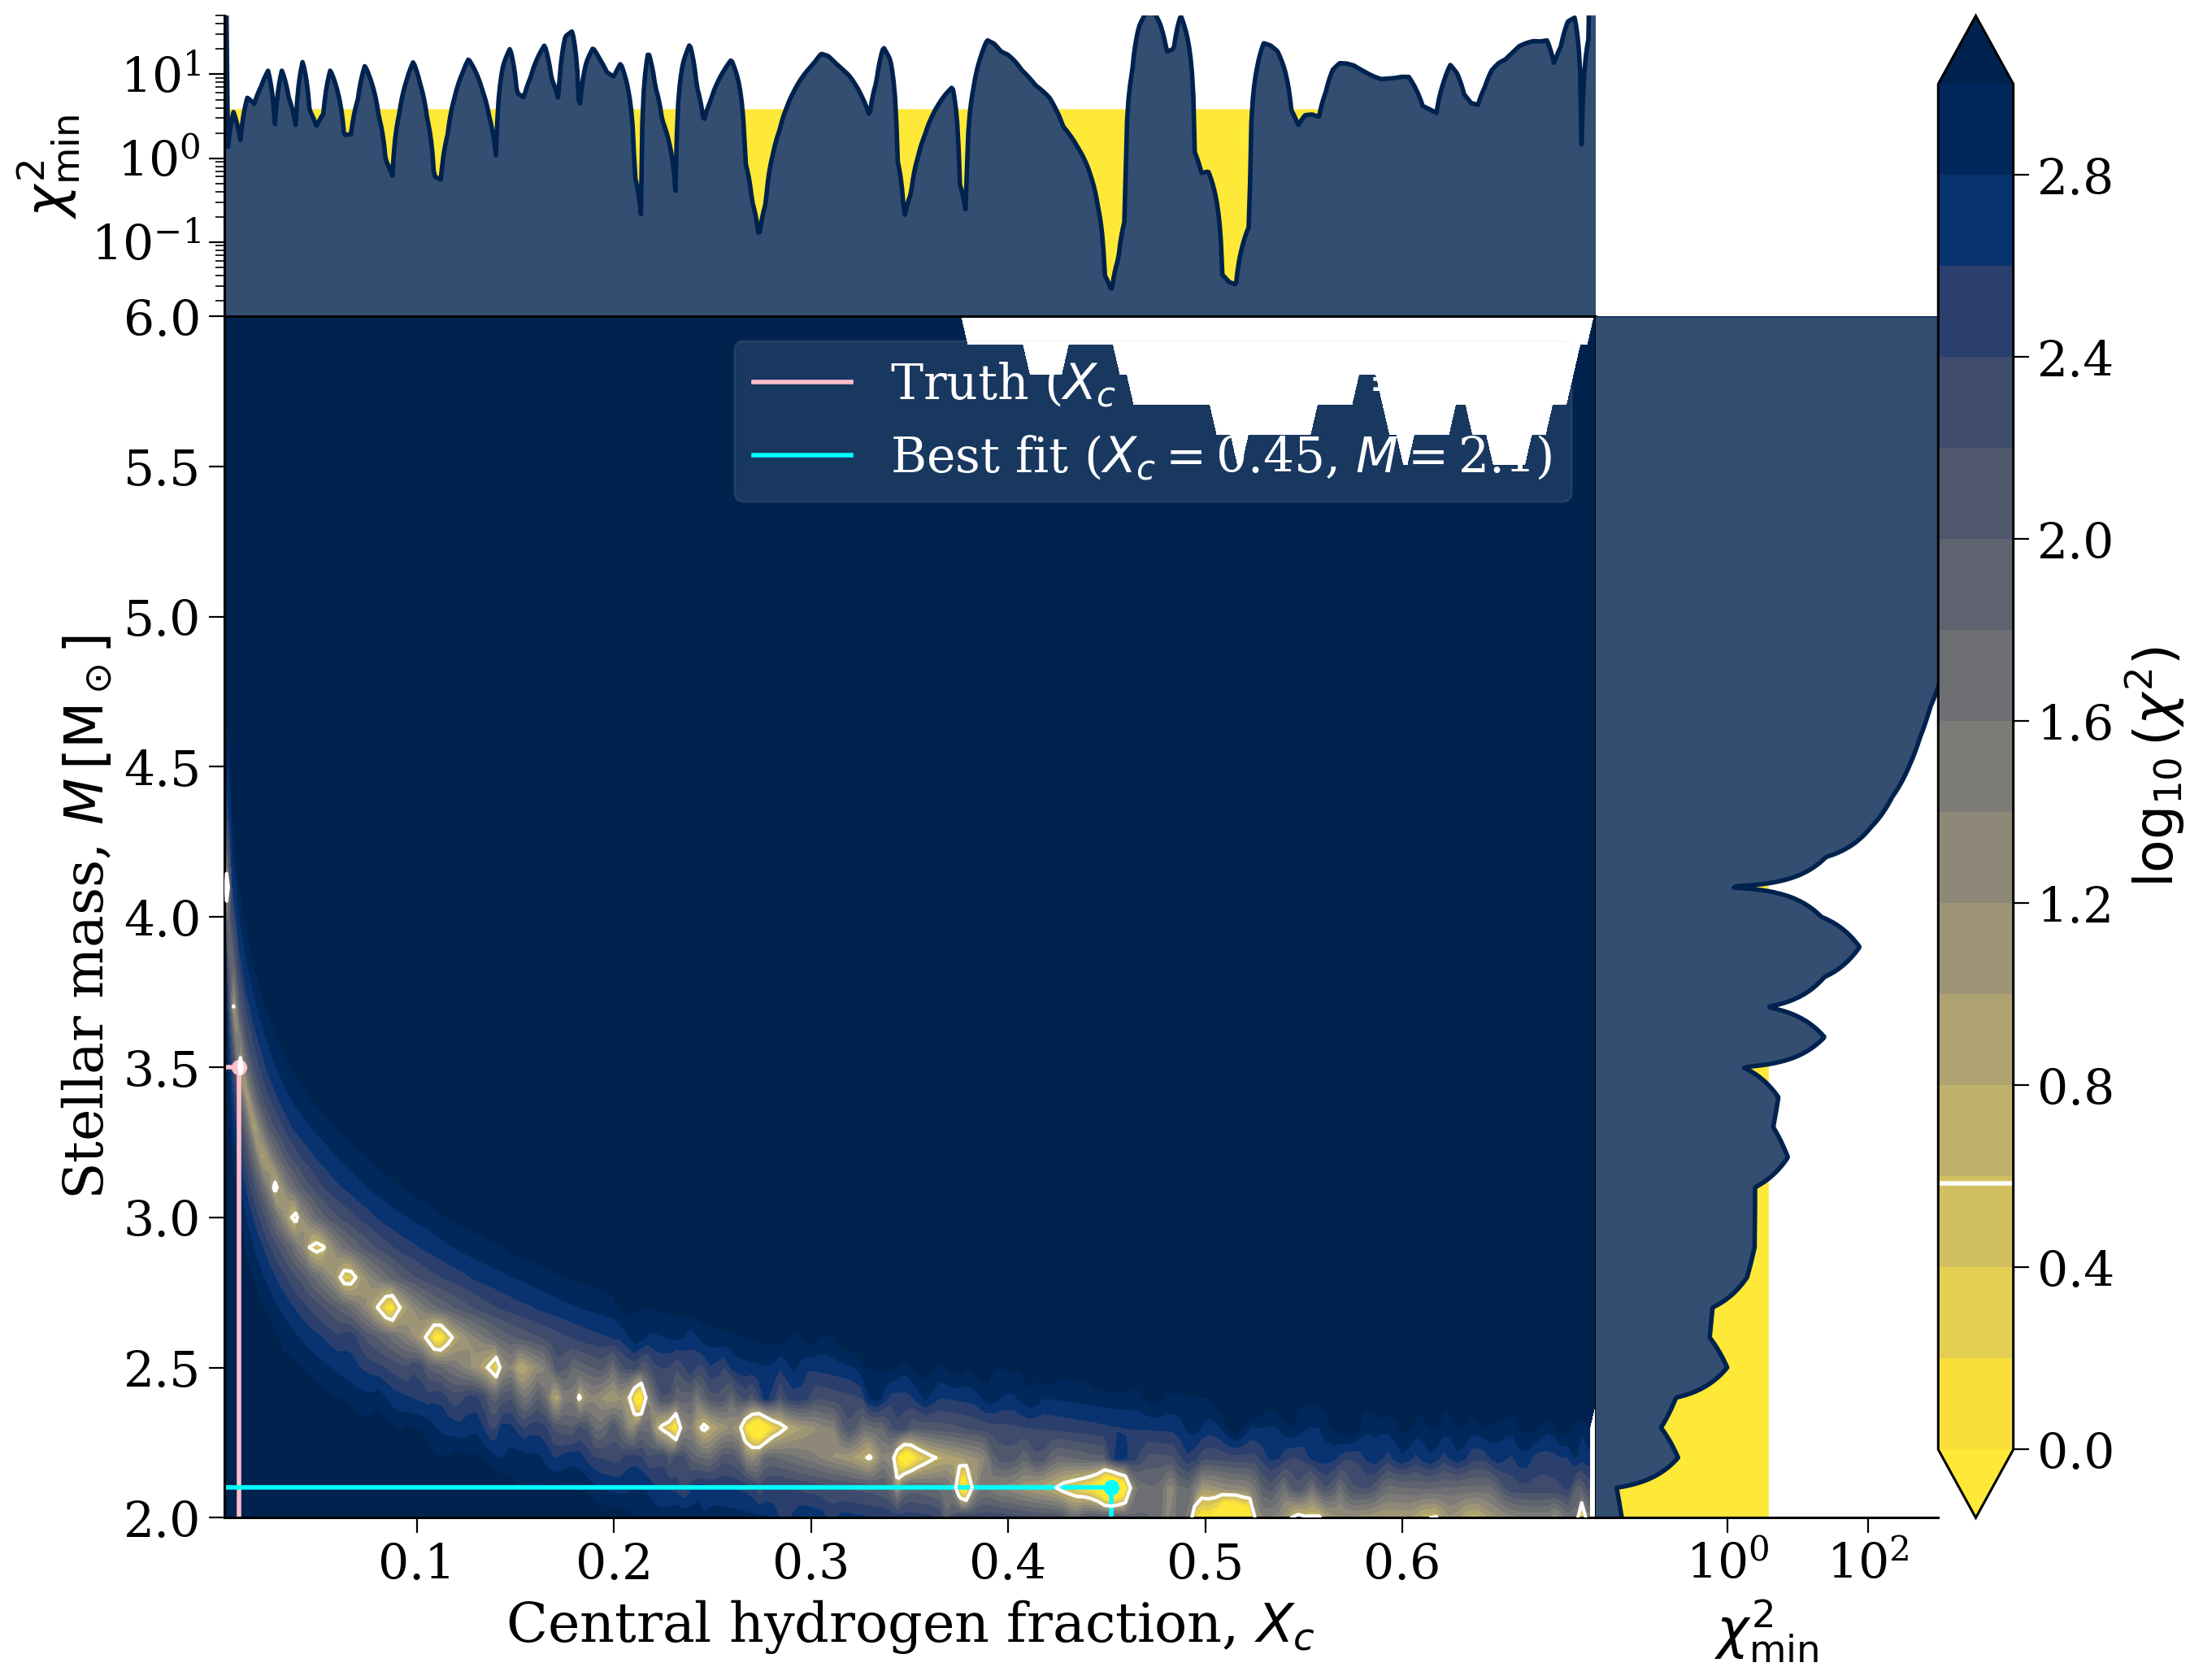

In [395]:
for X_c, chi in zip(X_c_range, chis_from_asp):
    plot_chis(chis=chi, X_c=X_c, save=False, marginals=True)

# 3. Compare relative estimates

In [13]:
def get_best_fit(chis):
    x_cs = [single_tracks[mod_name].history["center_h1"].values for mod_name in mod_names]

    chi_funcs = [interp1d(x_c, np.array(chi), fill_value="extrapolate") for x_c, chi in zip(x_cs, chis)]

    CHI = np.asarray([chi_funcs[i](x_c_range) for i in range(len(chi_funcs))])
    M_ind, x_c_ind = np.unravel_index(np.argmin(CHI), CHI.shape)

    return Ms[M_ind], x_c_range[x_c_ind], CHI.min(axis=0), CHI.min(axis=1)

In [99]:
def plot_relative_estimates(chis, save=None, show=True, title=None):
    best_fits = [get_best_fit(chis) for chis in chis]
    true_Ms = np.array([3.5, 3.5, 3.5, 3.5, 3.5, 3.5])
    true_Xcs = np.array([0.47, 0.4, 0.3, 0.2, 0.1, 0.01])

    best_Ms = [b[0] for b in best_fits]
    best_Xcs = [b[1] for b in best_fits]
    ages = track.history.loc[mpt.find_closest_model_number(track, X_c=X_c_range)]["star_age"].values

    X_c_to_ages = interp1d(true_Xcs, ages / 1e6, fill_value="extrapolate")
    ages_to_X_c = interp1d(ages, true_Xcs / 1e6, fill_value="extrapolate")

    fig, axes = plt.subplots(2, 1, figsize=(10, 11), sharex=True)

    axes[0].scatter(true_Xcs, true_Xcs, marker="+", label="Truth", color="black", s=150, zorder=10)
    axes[0].scatter(true_Xcs, best_Xcs, marker='o', label="Best Fit", color="black", s=50, zorder=10)

    c = "#992837"
    # axes[1].plot(true_Xcs, best_Ms, marker='o', label="Truth", color=c)
    # axes[1].fill_between(true_Xcs, best_Ms, true_Ms, alpha=0.2, color=c)
    axes[1].scatter(true_Xcs, true_Ms, marker="+", label="Truth", color="black", s=150, zorder=10)
    axes[1].scatter(true_Xcs, best_Ms, marker='o', label="Best Fit", color="black", s=50, zorder=10)

    for ax in axes:
        # ax.axhline(1, color='grey', linestyle='--', zorder=-1)
        # ax.axvspan(0.47, 0.51, color="grey", alpha=0.5)
        # ylims = ax.get_ylim()
        # ax.annotate("Accretion occurs", xy=(0.485, ylims[0] + (ylims[1] - ylims[0]) / 2), color="grey", fontsize=0.6 * fs, rotation=90, ha='center', va='center')
        ax.set_xlim(0.5, -0.02)
        
    # axes[0].annotate(r"Accretor $X_c$" + "\noverestimated", xy=(0.08, 1.5), ha="center", va="top", fontsize=0.7 * fs)
    # axes[0].annotate("", xytext=(0.08, 1.5), xy=(0.08, 2), ha="center", va="center", arrowprops=dict(arrowstyle="-|>, head_length=0.8, head_width=0.4", color='black', lw=1.8))
        
    # axes[1].annotate("Accretor mass\nunderestimated", xy=(0.08, 0.975), ha="center", va="bottom", fontsize=0.7 * fs)
    # axes[1].annotate("", xytext=(0.08, 0.975), xy=(0.08, 0.95), ha="center", va="center", arrowprops=dict(arrowstyle="-|>, head_length=0.8, head_width=0.4", color='black', lw=1.8))

    axes[0].set_ylabel(r"Fitted $X_c$", fontsize=1*fs)
    # axes[0].set_ylabel(r"$\frac{X_{c, \rm best{-}fit{-}single}}{X_{c, \rm true{-}accretor}}$", fontsize=1.2*fs)

    axes[1].set_xlabel(r"Accretor central hydrogen fraction, $X_c$")
    axes[1].set_ylabel(r"Fitted Mass, $M \, [\rm M_\odot]$", fontsize=1*fs)
    # axes[1].set_ylabel(r"$\frac{M_{\rm best{-}fit{-}single}}{M_{\rm true{-}accretor}}$", fontsize=1.2*fs)

    secax = axes[0].secondary_xaxis('top', functions=(X_c_to_ages, ages_to_X_c))
    secax.set_xlabel(r"Accretor age [Myr]", labelpad=10)

    for i in range(len(axes)):
        for bf, Xc in zip(best_fits, X_c_range):
            around = np.linspace(Xc - 0.02, Xc + 0.02, 100)
            # Y, A = np.meshgrid((x_c_range / Xc) if i == 0 else (Ms / 3.5), around)
            Y, A = np.meshgrid((x_c_range) if i == 0 else (Ms), around)

            # print(np.log10(np.tile(bf[2 + i], (100, 1))))
            
            cont = axes[i].contourf(A, Y, np.log10(np.tile(bf[2 + i], (100, 1))), vmax=3,
                                    cmap=cmap, levels=np.concatenate(([-2], np.linspace(-1, 3, 21), [500])),
                                    vmin=np.log10(2e-1), extend="both")
            for c in cont.collections:
                c.set_edgecolor("face")
                c.set_rasterized(True)
            # cont = axes[i].contourf(A, Y, np.log10(np.tile(bf[2 + i], (100, 1))), vmax=3,
            #                         cmap="bwr", levels=np.linspace(-1, 3, 210), norm=mpl.colors.CenteredNorm(vcenter=0.0))
                                    # vmin=np.log10(2e-1))
            # axes[i].contour(A, Y, np.log10(np.tile(bf[2 + i], (100, 1))), vmax=3,
            #                 levels=[np.log10(chi2(1).ppf(0.95))], colors="white", zorder=10)
            

    cbar = fig.colorbar(cont, ax=axes, label=r"$\log_{10}(\chi^2_{\rm min})$", extend="both")
    cbar.ax.set_yticks(np.linspace(-1, 3, 21)[::2])

    # add a legend to the first axis, in the middle of the x-axis but slightly below the y-axis
    axes[0].legend(ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1.027), framealpha=0.9, edgecolor="none",
                   fontsize=0.7*fs, handletextpad=0.0, markerscale=1.5, columnspacing=0.5)

    # plt.yscale("log")

    axes[1].set_xticks(X_c_range)
    # axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))

    axes[1].annotate("End of\naccretion", xy=(0.47, 6.4), ha="center", va="top", fontsize=0.5 * fs, annotation_clip=False)
    axes[1].annotate("End of\nMS", xy=(0.01, 6.4), ha="center", va="top", fontsize=0.5 * fs, annotation_clip=False)

    # axes[0].set_yscale("log")

    if title is not None:
        fig.suptitle(title, fontsize=1.2*fs, y=1.02)\

    if save is not None:
        plt.savefig(f"../paper/figures/{save}", format="pdf", bbox_inches="tight", dpi=300)

    if show:
        plt.show()
    return fig, ax

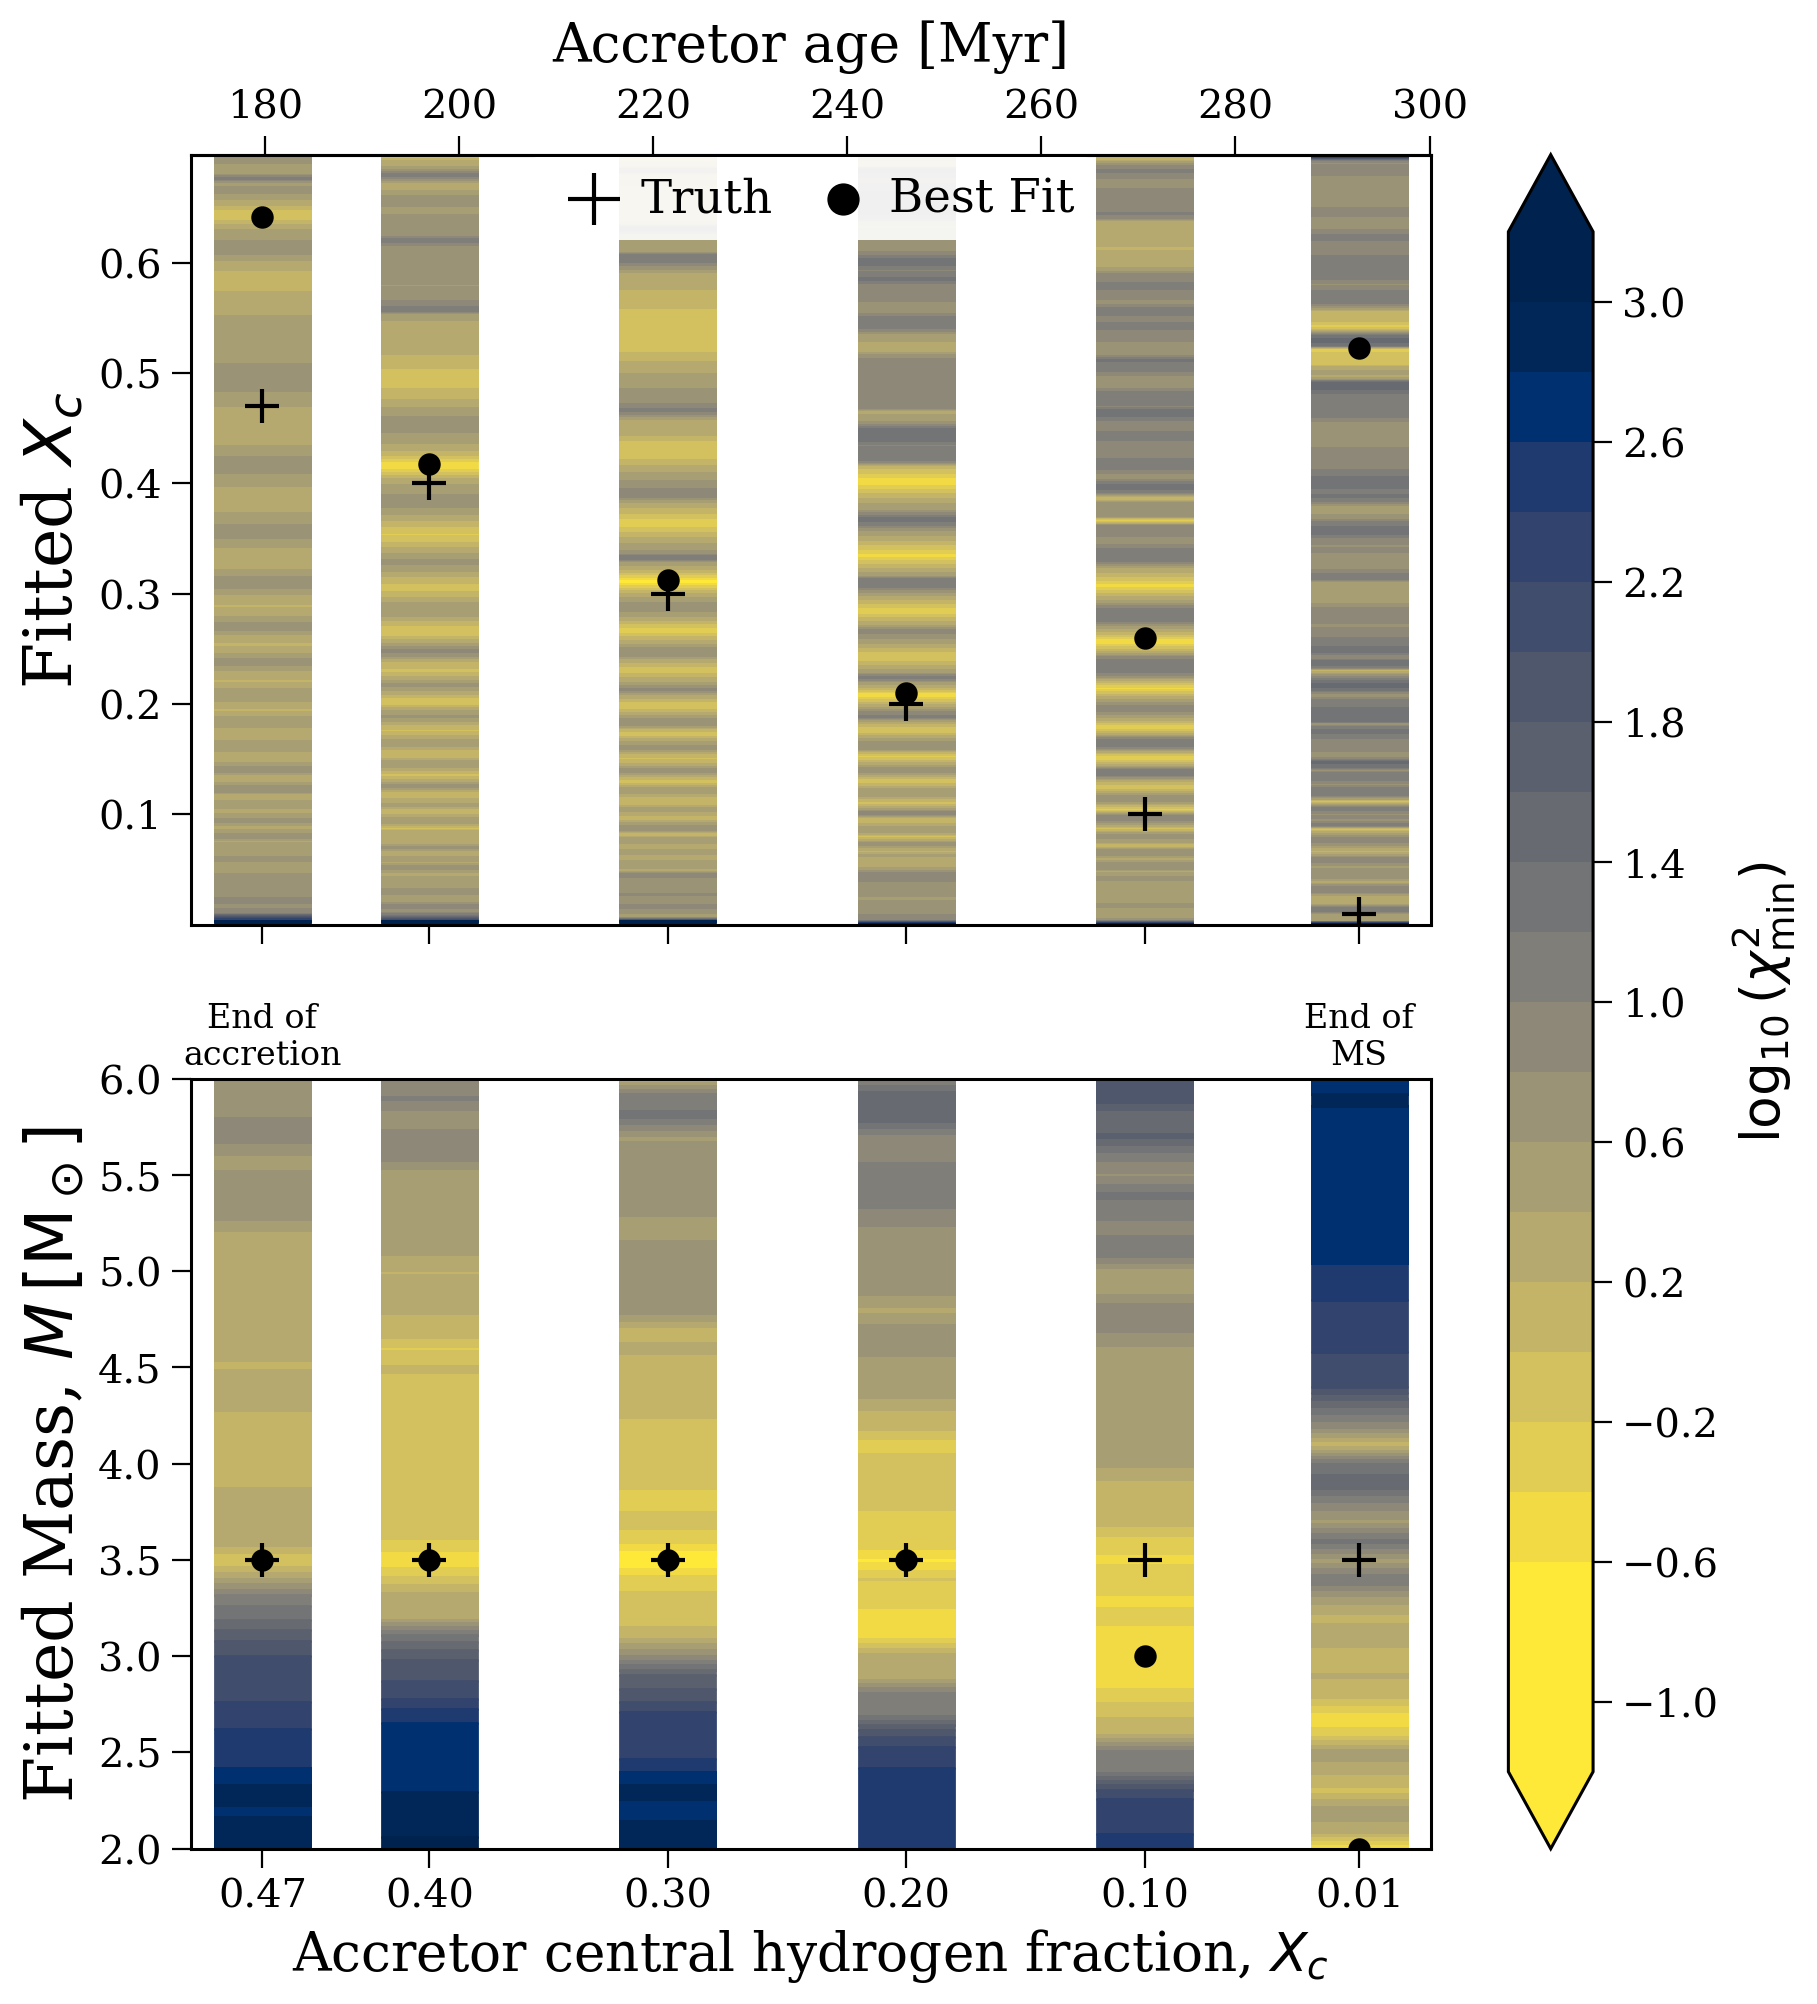

(<Figure size 1000x1100 with 3 Axes>,
 <Axes: xlabel='Accretor central hydrogen fraction, $X_c$', ylabel='Fitted Mass, $M \\, [\\rm M_\\odot]$'>)

In [100]:
# plot_relative_estimates(chi_sigma_1, title="Fit using period spacing")
plot_relative_estimates(chi_sigma_1, save="relative_estimates_psp.pdf")

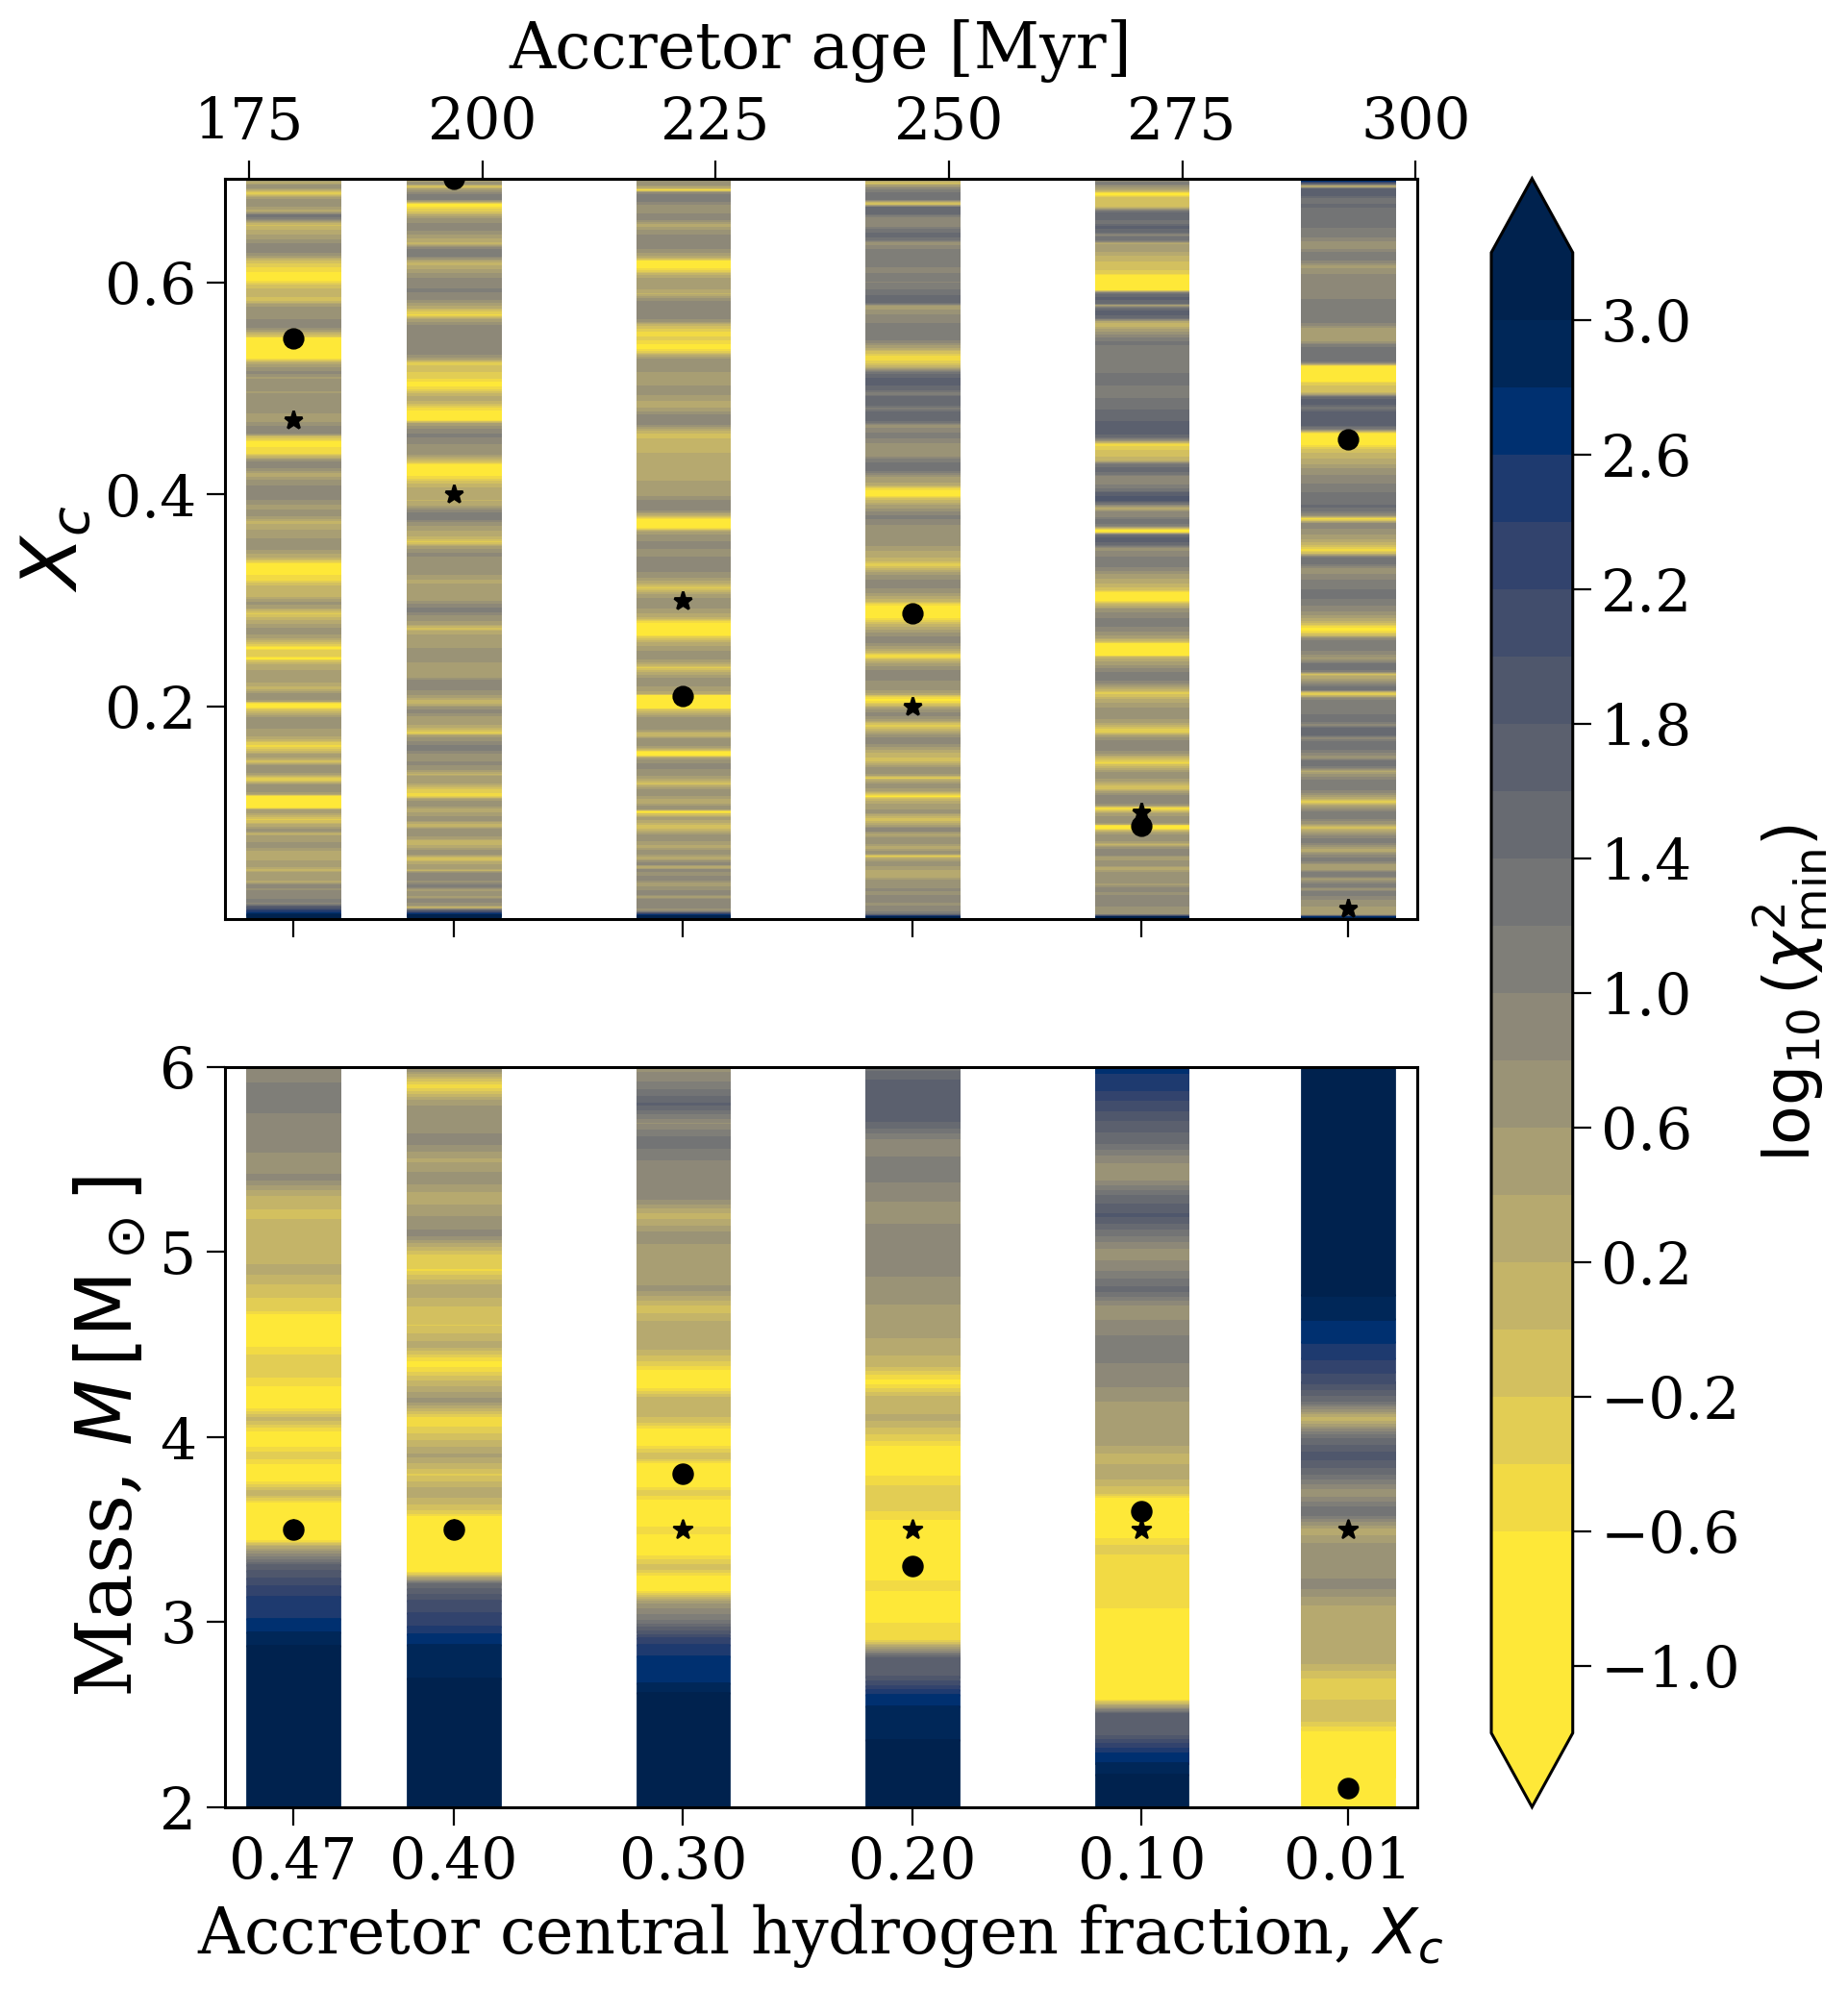

In [419]:
# fig, ax = plot_relative_estimates(chis_from_asp, title="Fit using asymptotic period spacing")
fig, ax = plot_relative_estimates(chis_from_asp, save="relative_estimates_asp.pdf")

# Old unused functions

In [ ]:
def chi2_2D(p_mg, dp_mg, p_s, dp_s, norm=None):
    if norm is None:
        norm = (dp_mg.max() - dp_mg.min()) / (p_mg.max() - p_mg.min())

    p_mg, dp_mg, p_s, dp_s = p_mg.value, dp_mg.value, p_s.value, dp_s.value

    p_diff = (p_mg[:, None] - p_s[None, :])**2
    dp_diff = ((p_mg[:, None] - p_s[None, :]) / norm)**2

    chi2 = np.min(p_diff + dp_diff, axis=1).sum()

    # sanity check
    assert np.isfinite(chi2)

    return chi2

In [ ]:
def chi_fixed_modes(p_s, p_mg=None, x=None, p_min=1.0, n_modes=20):
    """Calculate chi^2 using a fixed number of modes

    Parameters
    ----------
    p_s : `np.ndarray`
        Single star periods
    p_mg : `np.ndarray`, optional
        Mass-gainer periods, by default None
    x : `np.array`, optional
        Sorted and masked mass-gainer periods (for speed-ups), by default None
    p_min : `float`, optional
        Minimum period, by default 1.0
    n_modes : `int`, optional
        Number of modes to select, by default 20

    Returns
    -------
    chi2 : `float`
        chi^2 value
    """
    # if x is not directly supplied then compute it
    if x is None:
        # sort mass-gainer periods and remove units
        p_mg = np.sort(p_mg.to(u.d).value)

        # take the first n modes after period p_min
        x = p_mg[p_mg > p_min][:n_modes]

    # sort single star periods and remove units
    p_s = np.sort(p_s.to(u.d).value)

    # find the closest period to the starting mass-gainer period 
    y_start = np.abs(p_s - x[0]).argmin()

    # get the 20 modes after this matching period
    y = p_s[y_start:y_start + n_modes]

    # if for some reason there aren't 20 modes in either case then return infinity
    if len(y) != len(x) or len(x) != n_modes or len(y) != n_modes:
        return np.inf
    
    # calculate the cost matrix for the periods
    cost_matrix = np.zeros((len(x), len(y)))
    x_ind, y_ind = np.arange(len(x)), np.arange(len(y))
    for i, j in product(x_ind, y_ind):
        cost_matrix[i, j] = abs(x[i] - y[j])

    # use scipy to find the optimal assignment of modes
    opt_assignment = linear_sum_assignment(cost_matrix)

    # calculate chi^2
    measured_periods = x[opt_assignment[0]]
    model_periods = y[opt_assignment[1]]
    return np.sum((measured_periods - model_periods)**2)

In [135]:
def plot_chis_old_marginals(chis, X_c, truth_col='pink', best_fit_col='cyan', save=True, factor=1, marginals=False):
    x_cs = [single_tracks[mod_name].history["center_h1"].values for mod_name in mod_names]
    chi_funcs = [interp1d(x_c, np.array(chi), fill_value="extrapolate") for x_c, chi in zip(x_cs, chis)]

    x_c_range = np.linspace(1e-5, 0.698, 200)

    XC, M = np.meshgrid(x_c_range, Ms)

    CHI = np.asarray([chi_funcs[i](x_c_range) for i in range(len(chi_funcs))])
    CHI *= factor
    CHI[CHI > 100000] = np.inf

    critical_value = chi2(1).ppf(0.95)
    critical_value = CHI.min() + 1

    if marginals:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                                 gridspec_kw={"hspace": 0, "wspace": 0, 
                                              "height_ratios": [1, 4], "width_ratios": [4, 1]})
        ax = axes[1, 0]
        axes[0, 1].axis("off")
    else:
        fig, ax = plt.subplots()

    levels = np.linspace(0, 3, 16)
    cont = ax.contourf(XC, M, np.log10(CHI), levels=levels, cmap=cmap, extend='both')
    ax.contour(XC, M, np.log10(CHI), levels=[np.log10(critical_value)], colors="white", zorder=10)
    for c in cont.collections:
        c.set_edgecolor("face")
        c.set_rasterized(True)
    cbar = fig.colorbar(cont, label=r"$\log_{10}(\chi^2)$", ax=axes, pad=0.0)
    
    # plot a white line to colourbar critical chi^2 value
    cbar.ax.plot([0, 1], [np.log10(critical_value)]*2, color="white", lw=2)

    M_ind, x_c_ind = np.unravel_index(np.argmin(CHI), CHI.shape)

    print(X_c, f'{x_c_range[x_c_ind]:1.3f}', f'{Ms[M_ind]:1.3f}')

    xlims, ylims = ax.get_xlim(), ax.get_ylim()

    lw, ls, bf_ls = 2, "-", '-'

    ax.plot([X_c, X_c], [2.0, 3.5], color=truth_col, linestyle=ls, lw=lw,
            label=r"Truth ($X_c = $" + f"{X_c}, " + r"$M = $" + "3.5)")
    ax.plot([0, X_c], [3.5, 3.5], color=truth_col, linestyle=ls, lw=lw)
    ax.scatter(X_c, 3.5, color=truth_col, s=35)

    ax.plot([x_c_range[x_c_ind], x_c_range[x_c_ind]], [2.0, Ms[M_ind]], color=best_fit_col, linestyle=bf_ls, lw=lw,
            label=r"Best fit ($X_c = $" + f"{x_c_range[x_c_ind]:1.2f}, " + r"$M = $" + f"{Ms[M_ind]:1.1f})")
    ax.plot([0, x_c_range[x_c_ind]], [Ms[M_ind], Ms[M_ind]], color=best_fit_col, linestyle=bf_ls, lw=lw)
    ax.scatter(x_c_range[x_c_ind], Ms[M_ind], color=best_fit_col, s=35)

    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlim(left=2.5e-3)

    ax.legend(loc="best", framealpha=0.1, labelcolor="white", fontsize=0.9*fs)

    ax.set_xlabel(r"Central hydrogen fraction, $X_c$", fontsize=fs)
    ax.set_ylabel(r"Stellar mass, $M \, [\rm M_\odot]$", fontsize=fs)

    if marginals:
        Xc_smooth = np.linspace(0, 0.7, 1000)
        CHI_smooth = interp1d(x_c_range, CHI.min(axis=0), fill_value="extrapolate")(Xc_smooth)
        axes[0, 0].plot(Xc_smooth, CHI_smooth, color=cmap(0.999), lw=2)
        axes[0, 0].fill_between(Xc_smooth, CHI_smooth, alpha=0.8, color=cmap(0.999))
        axes[0, 0].set(xlim=ax.get_xlim(), ylim=(CHI.min() * 0.5, CHI_smooth.max() + 1), yscale="log", ylabel=r"$\chi^2_{\rm min}$")
        axes[0, 0].spines[["bottom", "top", "right"]].set_visible(False)
        # axes[0, 0].axhline(chi2(1).ppf(0.95), color="white", linestyle="-")
        axes[0, 0].fill_between(Xc_smooth, CHI_smooth, critical_value,
                                where=CHI_smooth <= critical_value, facecolor=cmap(0.0), lw=2)

        M_smooth = np.linspace(2.0, 6.0, 1000)
        CHI_smooth = interp1d(Ms, CHI.min(axis=1), fill_value="extrapolate")(M_smooth)
        axes[1, 1].plot(CHI_smooth, M_smooth, color=cmap(0.999), lw=2)
        axes[1, 1].fill_betweenx(y=M_smooth, x1=CHI_smooth, alpha=0.8, color=cmap(0.999))
        axes[1, 1].set(ylim=ax.get_ylim(), xlim=(CHI.min() * 0.5, 1000), xscale="log", xlabel=r"$\chi^2_{\rm min}$")
        axes[1, 1].spines[["left", "top", "right"]].set_visible(False)
        axes[1, 1].set_yticks([])
        # axes[1, 1].axvline(chi2(1).ppf(0.95), color="white")
        axes[1, 1].fill_betweenx(y=M_smooth, x1=CHI_smooth, x2=critical_value,
                                where=CHI_smooth <= critical_value, facecolor=cmap(0.0), zorder=100)

    if save:
        plt.savefig(f"../paper/figures/chi2_xc_{X_c}.pdf", format="pdf", bbox_inches="tight", dpi=300)

    plt.show()